# 目標
- 小さなデータでsubmissionを目指す.

In [5]:
import sys
sys.path.append("../yandex/")
#sys.path.append("../lib/")
import os
import pandas as pd

import utils
import scoring
import calc_var as cv

#from xgboost import XGBClassifier
import xgboost as xgb
import xgbfir
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

from hyperopt import fmin, tpe, hp, rand
import optuna

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import swifter
%matplotlib inline
%load_ext autoreload

pd.set_option('display.max_columns', 200)
pd.set_option("display.max_rows", 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



# データの準備

In [2]:
DATA_PATH = "../your_data_dir/"

In [3]:
#train, test = utils.load_data_csv(
#    DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS)

In [4]:
train = utils.load_data_csv_part(DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS, "train_part_2")

/Users/m_nakao/.pyenv/versions/anaconda3-2.4.1/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
valid = utils.load_data_csv_part(DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS, "train_part_1")

/Users/m_nakao/.pyenv/versions/anaconda3-2.4.1/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
test = utils.load_test_private_csv(DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS)

/Users/m_nakao/.pyenv/versions/anaconda3-2.4.1/envs/py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## event数を絞る

In [7]:
sample = train.copy()

In [8]:
#sample = sample.sample(400000)

In [9]:
sample.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  avg_cs[3]  \
0      28      21      13       7   2.107143   1.761905   1.384615   1.000000   
1      75      53       6       8   2.306667   4.433962   2.000000   1.000000   
2      50      27      11      14   2.340000   1.962963   1.454546   1.285714   
3      79      13       7      14   2.506329   1.461538   1.571428   1.500000   
4      25       7      12       6   2.160000   1.571428   2.666667   1.333333   

   ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  MatchedHit_TYPE[2]  \
0     8                   2                   2                   2   
1     8                   2                   2                   2   
2     8                   2                   2                   2   
3     8                   2                   2                   1   
4     8                   2                   2                   2   

   MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  MatchedHit_X[2]  \
0                   2        971.92500       1061.93500          1147.60   
1                   2        145.00000        100.96000            60.00   
2                   2        276.07500        311.38500           327.60   
3                   1        384.55832        394.11835           397.90   
4                   2      -1023.70500      -1090.57500         -1160.87   

   MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  MatchedHit_Y[2]  \
0          1227.22        -95.76171       -103.40795      -111.084854   
1           -63.17       1709.42530       1843.17810      2108.600800   
2           414.52       -595.55597       -642.90200      -690.278600   
3           426.62       -237.55830       -256.45447      -275.381320   
4         -1240.07       -924.84330       -997.92800     -1069.891600   

   MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  MatchedHit_Z[2]  \
0       -119.07685       15203.6540        16410.928        17604.500   
1       2242.16400       15327.1560        16534.938        17612.492   
2       -737.97034       15117.8545        16324.984        17518.414   
3       -294.62323       15119.1440        16326.376        17519.908   
4      -1140.22020       15399.7705        16603.707        17796.248   

   MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  MatchedHit_DX[2]  \
0        18813.371          6.375000          6.875000         29.500000   
1        18731.273         12.750000         13.750000         59.000000   
2        18727.143          6.375000          6.875000         29.500000   
3        18728.738          3.208333          3.458333         14.833333   
4        19004.096          6.375000          6.875000         29.500000   

   MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
0         31.500000         31.479162         33.979145         36.479130   
1         63.000000         63.078957         68.078926         73.078896   
2         31.500000         31.479162         33.979145         36.479130   
3         15.833333         15.679264         16.929256         18.179249   
4         31.500000         31.479162         33.979145         36.479130   

   MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  MatchedHit_DZ[2]  \
0         38.979115         33.613575         33.622578         33.631580   
1         78.078860         33.727364         33.745370         33.763374   
2         38.979115         33.613575         33.622578         33.631580   
3         19.429240         33.556680         33.561180         33.565680   
4         38.979115         33.613575         33.622578         33.631580   

   MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  MatchedHit_T[2]  \
0         33.640583                4                5                3   
1         33.781380                8               11                8   
2         33.640583                6                5                4   
3         33.570183                7                7                3   
4

In [10]:
sample.describe()

ncl[0]        ncl[1]        ncl[2]        ncl[3]     avg_cs[0]  \
count  2.722853e+06  2.722853e+06  2.722853e+06  2.722853e+06  2.722853e+06   
mean   6.274929e+01  1.952295e+01  1.243221e+01  1.300992e+01  2.465753e+00   
std    3.223642e+01  1.267186e+01  7.444328e+00  6.378158e+00  6.574461e-01   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
25%    3.800000e+01  1.000000e+01  7.000000e+00  8.000000e+00  2.011111e+00   
50%    5.700000e+01  1.700000e+01  1.100000e+01  1.200000e+01  2.387097e+00   
75%    8.200000e+01  2.600000e+01  1.600000e+01  1.600000e+01  2.821429e+00   
max    3.090000e+02  1.890000e+02  9.100000e+01  8.700000e+01  1.334783e+01   

          avg_cs[1]     avg_cs[2]     avg_cs[3]          ndof  \
count  2.722853e+06  2.722853e+06  2.722853e+06  2.722853e+06   
mean   2.117003e+00  1.446624e+00  1.360047e+00  7.931061e+00   
std    7.774184e-01  3.672972e-01  4.328015e-01  4.019743e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  4.000000e+00   
25%    1.571428e+00  1.187500e+00  1.125000e+00  8.000000e+00   
50%    2.000000e+00  1.384615e+00  1.285714e+00  8.000000e+00   
75%    2.500000e+00  1.636364e+00  1.500000e+00  8.000000e+00   
max    5.800000e+01  1.340000e+01  3.200000e+01  8.000000e+00   

       MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  MatchedHit_TYPE[2]  \
count        2.722853e+06        2.722853e+06        2.722853e+06   
mean         1.962484e+00        1.964524e+00        1.799698e+00   
std          1.900220e-01        1.849788e-01        4.394204e-01   
min          1.000000e+00        1.000000e+00        0.000000e+00   
25%          2.000000e+00        2.000000e+00        2.000000e+00   
50%          2.000000e+00        2.000000e+00        2.000000e+00   
75%          2.000000e+00        2.000000e+00        2.000000e+00   
max          2.000000e+00        2.000000e+00        2.000000e+00   

       MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  MatchedHit_X[2]  \
count        2.722853e+06     2.722853e+06     2.722853e+06     2.722853e+06   
mean         1.787854e+00     1.086977e+00     1.149046e+00    -1.630961e+02   
std          4.507437e-01     1.548380e+03     1.691120e+03     2.219887e+03   
min          0.000000e+00    -4.860640e+03    -5.243800e+03    -9.999000e+03   
25%          2.000000e+00    -8.139150e+02    -8.810750e+02    -1.025870e+03   
50%          2.000000e+00     7.558333e+00     8.885000e+00    -3.557000e+01   
75%          2.000000e+00     8.189250e+02     8.901850e+02     9.186000e+02   
max          2.000000e+00     4.883950e+03     5.224610e+03     5.557000e+03   

       MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  MatchedHit_Y[2]  \
count     2.722853e+06     2.722853e+06     2.722853e+06     2.722853e+06   
mean     -1.807085e+02    -4.498429e+00    -5.217280e+00    -1.691638e+02   
std       2.347292e+03     1.346692e+03     1.450558e+03     1.991976e+03   
min      -9.999000e+03    -3.951224e+03    -4.259907e+03    -9.999000e+03   
25%      -1.114070e+03    -7.938417e+02    -8.570264e+02    -9.589832e+02   
50%      -4.137000e+01    -3.256212e+01    -3.520839e+01    -7.408261e+01   
75%       9.822200e+02     7.834494e+02     8.441639e+02     9.010019e+02   
max       5.933120e+03     3.898132e+03     4.205364e+03     4.512695e+03   

       MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  MatchedHit_Z[2]  \
count     2.722853e+06     2.722853e+06     2.722853e+06     2.722853e+06   
mean     -1.835633e+02     1.526137e+04     1.646712e+04     1.720517e+04   
std       2.091086e+03     1.084856e+02     1.086861e+02     3.520333e+03   
min      -9.999000e+03     1.510503e+04     1.630819e+04    -9.999000e+03   
25%      -1.023975e+03     1.519077e+04     1.639407e+04     1.752845e+04   
50%      -7.892335e+01     1.525878e+04     1.646381e+04     1.761485e+04   
75%       9.022665e+02     1.533240e+04     1.654060e+04     1.773140e+04   
max       4.820811e+03     1.541831e+04     1.662665e+04     1

## 新しい特徴量を追加する

In [7]:
%autoreload

In [28]:
sample = (cv.MeasCalculator()).calc_all(sample)
sample = (cv.MeasCalculator()).check_MatchedHitPattern(sample)
sample = (cv.MeasCalculator()).calc_newfeature(sample)
sample = (cv.MeasCalculator()).calc_newfeature_sq(sample)

In [13]:
#sample = sample.swifter.apply(
#    cv.RowWiseCalculator().calc_all, result_type="expand", axis=1)

In [14]:
sample.tail()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
2722848      50      17       4      11   1.940000   3.000000   1.250000   
2722849      28       5       3      10   1.785714   3.000000   1.000000   
2722850     121      57      21      14   2.363636   2.982456   1.428572   
2722851      43       5       9       9   3.441860   1.800000   1.111111   
2722852      37      11       5       6   2.621622   2.545454   1.000000   

         avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
2722848   1.272727     8                   2                   2   
2722849   1.100000     8                   2                   2   
2722850   1.285714     8                   2                   2   
2722851   1.222222     8                   2                   2   
2722852   1.000000     8                   2                   2   

         MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
2722848                   2                   2         1442.100   
2722849                   2                   2         3618.250   
2722850                   1                   1         -533.255   
2722851                   2                   2           59.325   
2722852                   2                   2         2468.450   

         MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
2722848         1529.060          1568.60          1677.82       -690.35535   
2722849         3919.910          4297.70          4593.72      -1133.35500   
2722850         -596.675          -672.17          -718.47       -366.04443   
2722851           63.885            91.60            99.52       -721.95514   
2722852         2693.110          2920.40          3121.02      -2408.84810   

         MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
2722848       -745.20130       -800.07790       -855.26960        15117.513   
2722849      -1216.89820      -1306.47460      -1396.36610        15199.918   
2722850       -395.67938       -424.19327       -451.07224        15317.782   
2722851       -779.30110       -836.67770       -894.36930        15117.399   
2722852      -2850.99020      -3059.56570      -3268.55640        15312.326   

         MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
2722848        16324.615        17518.018        18726.719         12.750000   
2722849        16322.917        17516.195        18724.771         25.500000   
2722850        16521.875        17714.572        18922.576          3.208333   
2722851        16324.493        17517.887        18726.578          6.375000   
2722852        16401.033        17593.883        18802.030         25.500000   

         MatchedHit_DX[1]  MatchedHit_DX[2]  MatchedHit_DX[3]  \
2722848         13.750000         59.000000         63.000000   
2722849         27.500000        118.000000        126.000000   
2722850          3.458333         14.833333         15.833333   
2722851          6.875000         29.500000         31.500000   
2722852         27.500000        118.000000        126.000000   

         MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
2722848         63.078957         68.078926         73.078896   
2722849        126.278550        136.278490        146.278410   
2722850         15.679264         16.929256         18.179249   
2722851         31.479162         33.979145         36.479130   
2722852        126.278550        136.278490        146.278410   

         MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
2722848         78.078860         33.727364         33.745370   
2722849        156.278350         33.954950         33.990960   
2722850         19.429240         33.556680         33.561180   
2722851         38.979115         33.613575         33.622578   
2722852        156.278350         33.954950         33.990960   

         MatchedHit_DZ[2]  MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  \
2722848         33.763374         33.781380      

In [15]:
sample.columns

Index(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       ...
       'chi_physX3', 'chi_modelX3', 'chi_bothX3', 'chi_physY3', 'chi_modelY3',
       'chi_bothY3', 'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3'],
      dtype='object', length=133)

In [16]:
sample.dtypes

ncl[0]                       int64
ncl[1]                       int64
ncl[2]                       int64
ncl[3]                       int64
avg_cs[0]                  float64
avg_cs[1]                  float64
avg_cs[2]                  float64
avg_cs[3]                  float64
ndof                         int64
MatchedHit_TYPE[0]           int64
MatchedHit_TYPE[1]           int64
MatchedHit_TYPE[2]           int64
MatchedHit_TYPE[3]           int64
MatchedHit_X[0]            float64
MatchedHit_X[1]            float64
MatchedHit_X[2]            float64
MatchedHit_X[3]            float64
MatchedHit_Y[0]            float64
MatchedHit_Y[1]            float64
MatchedHit_Y[2]            float64
MatchedHit_Y[3]            float64
MatchedHit_Z[0]            float64
MatchedHit_Z[1]            float64
MatchedHit_Z[2]            float64
MatchedHit_Z[3]            float64
MatchedHit_DX[0]           float64
MatchedHit_DX[1]           float64
MatchedHit_DX[2]           float64
MatchedHit_DX[3]    

In [9]:
test = (cv.MeasCalculator()).calc_all(test)
test = (cv.MeasCalculator()).check_MatchedHitPattern(test)
test = (cv.MeasCalculator()).calc_newfeature(test)
test = (cv.MeasCalculator()).calc_newfeature_sq(test)

In [18]:
#test = test.swifter.apply(
#    cv.RowWiseCalculator().calc_all, result_type="expand", axis=1)

In [29]:
valid = (cv.MeasCalculator()).calc_all(valid)
valid = (cv.MeasCalculator()).check_MatchedHitPattern(valid)
valid = (cv.MeasCalculator()).calc_newfeature(valid)
valid = (cv.MeasCalculator()).calc_newfeature_sq(valid)

## カラムを絞る
- とりあえず以下のものだけ抜き出す.
    - 評価用
        - label
        - weight
        - particle_type
    - 特徴量
        - PT
        - P
        - FOI_hits_N
        - ncl[0]
        - avg_cs[0]

In [10]:
FEATURE_COLUMNS2 = ['MatchedHit_R_01', 'MatchedHit_R_1', 'MatchedHit_R_0',
    'region_0',  'region_1',  'region_2',  'region_3', 
    'FOI_hits_N', 'PT', 'P', 'PCat', 'PRatio',
    'DiffMatchedLextra_X[0]', 'DiffMatchedLextra_X[1]', 'DiffMatchedLextra_X[2]', 'DiffMatchedLextra_X[3]', 
    'DiffMatchedLextra_Y[0]', 'DiffMatchedLextra_Y[1]', 'DiffMatchedLextra_Y[2]', 'DiffMatchedLextra_Y[3]', 
    'InvASD3', 
    'chi_physX0', 'chi_modelX0', 'chi_physY0', 'chi_modelY0',
    'chi_physX1', 'chi_modelX1', 'chi_physY1', 'chi_modelY1', 
    'chi_physX2', 'chi_modelX2', 'chi_physY2', 'chi_modelY2',
    'chi_physX3', 'chi_modelX3', 'chi_physY3', 'chi_modelY3',
    'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3',
    'MatchedHitPattern1', 'MatchedHitPattern2', 
    'sq_PT', 'sq_P']

In [11]:
FEATURE_COLUMNS2_NOBRACKET = ['MatchedHit_R_01', 'MatchedHit_R_1', 'MatchedHit_R_0',
    'region_0',  'region_1',  'region_2',  'region_3', 
    'FOI_hits_N', 'PT', 'P', 'PCat', 'PRatio',
    'DiffMatchedLextra_X_0', 'DiffMatchedLextra_X_1', 'DiffMatchedLextra_X_2', 'DiffMatchedLextra_X_3', 
    'DiffMatchedLextra_Y_0', 'DiffMatchedLextra_Y_1', 'DiffMatchedLextra_Y_2', 'DiffMatchedLextra_Y_3', 
    'InvASD3', 
    'chi_physX0', 'chi_modelX0', 'chi_physY0', 'chi_modelY0',
    'chi_physX1', 'chi_modelX1', 'chi_physY1', 'chi_modelY1', 
    'chi_physX2', 'chi_modelX2', 'chi_physY2', 'chi_modelY2',
    'chi_physX3', 'chi_modelX3', 'chi_physY3', 'chi_modelY3',
    'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3',
    'MatchedHitPattern1', 'MatchedHitPattern2', 
    'sq_PT', 'sq_P']

In [ ]:
FEATURE_COLUMNS2 = ['ncl[0]','ncl[1]','ncl[2]','ncl[3]','avg_cs[0]','avg_cs[1]','avg_cs[2]','avg_cs[3]',
                    'ndof','MatchedHit_TYPE[0]','MatchedHit_TYPE[1]','MatchedHit_TYPE[2]','MatchedHit_TYPE[3]',
                    'MatchedHit_X[0]','MatchedHit_X[1]','MatchedHit_X[2]','MatchedHit_X[3]',
                    'MatchedHit_Y[0]','MatchedHit_Y[1]','MatchedHit_Y[2]','MatchedHit_Y[3]',
                    'MatchedHit_Z[0]','MatchedHit_Z[1]','MatchedHit_Z[2]','MatchedHit_Z[3]',
                    'MatchedHit_DX[0]','MatchedHit_DX[1]','MatchedHit_DX[2]','MatchedHit_DX[3]',
                    'MatchedHit_DY[0]','MatchedHit_DY[1]','MatchedHit_DY[2]','MatchedHit_DY[3]',
                    'MatchedHit_DZ[0]','MatchedHit_DZ[1]','MatchedHit_DZ[2]','MatchedHit_DZ[3]',
                    'MatchedHit_T[0]','MatchedHit_T[1]','MatchedHit_T[2]','MatchedHit_T[3]',
                    'MatchedHit_DT[0]','MatchedHit_DT[1]','MatchedHit_DT[2]','MatchedHit_DT[3]',
                    'Lextra_X[0]','Lextra_X[1]','Lextra_X[2]','Lextra_X[3]',
                    'Lextra_Y[0]','Lextra_Y[1]','Lextra_Y[2]','Lextra_Y[3]',
                    'NShared',
                    'Mextra_DX2[0]','Mextra_DX2[1]','Mextra_DX2[2]','Mextra_DX2[3]',
                    'Mextra_DY2[0]','Mextra_DY2[1]','Mextra_DY2[2]','Mextra_DY2[3]',
                    'FOI_hits_N','PT','P','particle_type','label','weight','PCat','PRatio','PL',
                    'DiffMatchedLextra_X[0]','DiffMatchedLextra_X[1]','DiffMatchedLextra_X[2]','DiffMatchedLextra_X[3]',
                    'DiffMatchedLextra_Y[0]','DiffMatchedLextra_Y[1]','DiffMatchedLextra_Y[2]','DiffMatchedLextra_Y[3]',
                    'AverageSquaredDistance3','Nhit','InvASD3',
                    'chi_root_physX0','chi_root_modelX0','chi_root_bothX0',
                    'chi_root_physY0','chi_root_modelY0','chi_root_bothY0',
                    'chi_root_physX1','chi_root_modelX1','chi_root_bothX1',
                    'chi_root_physY1','chi_root_modelY1','chi_root_bothY1',
                    'chi_root_physX2','chi_root_modelX2','chi_root_bothX2',
                    'chi_root_physY2','chi_root_modelY2','chi_root_bothY2',
                    'chi_root_physX3','chi_root_modelX3','chi_root_bothX3',
                    'chi_root_physY3','chi_root_modelY3','chi_root_bothY3',
                    'FOI_N0','FOI_N1','FOI_N2','FOI_N3','sq_PT','sq_P',
                    'region_0','region_1','region_2','region_3',
                    'MatchedHit_R_0','MatchedHit_R_1','MatchedHit_R_2','MatchedHit_R_3',
                    'MatchedHit_R_01','MatchedHit_R_12','MatchedHit_R_23']                    
                    
                    

In [112]:
FEATURE_COLUMNS2_NOBRACKET = ['ncl_0','ncl_1','ncl_2','ncl_3','avg_cs_0','avg_cs_1','avg_cs_2','avg_cs_3',
                    'ndof','MatchedHit_TYPE_0','MatchedHit_TYPE_1','MatchedHit_TYPE_2','MatchedHit_TYPE_3',
                    'MatchedHit_X_0','MatchedHit_X_1','MatchedHit_X_2','MatchedHit_X_3',
                    'MatchedHit_Y_0','MatchedHit_Y_1','MatchedHit_Y_2','MatchedHit_Y_3',
                    'MatchedHit_Z_0','MatchedHit_Z_1','MatchedHit_Z_2','MatchedHit_Z_3',
                    'MatchedHit_DX_0','MatchedHit_DX_1','MatchedHit_DX_2','MatchedHit_DX_3',
                    'MatchedHit_DY_0','MatchedHit_DY_1','MatchedHit_DY_2','MatchedHit_DY_3',
                    'MatchedHit_DZ_0','MatchedHit_DZ_1','MatchedHit_DZ_2','MatchedHit_DZ_3',
                    'MatchedHit_T_0','MatchedHit_T_1','MatchedHit_T_2','MatchedHit_T_3',
                    'MatchedHit_DT_0','MatchedHit_DT_1','MatchedHit_DT_2','MatchedHit_DT_3',
                    'Lextra_X_0','Lextra_X_1','Lextra_X_2','Lextra_X_3',
                    'Lextra_Y_0','Lextra_Y_1','Lextra_Y_2','Lextra_Y_3',
                    'NShared',
                    'Mextra_DX2_0','Mextra_DX2_1','Mextra_DX2_2','Mextra_DX2_3',
                    'Mextra_DY2_0','Mextra_DY2_1','Mextra_DY2_2','Mextra_DY2_3',
                    'FOI_hits_N','PT','P','particle_type','label','weight','PCat','PRatio','PL',
                    'DiffMatchedLextra_X_0','DiffMatchedLextra_X_1','DiffMatchedLextra_X_2','DiffMatchedLextra_X_3',
                    'DiffMatchedLextra_Y_0','DiffMatchedLextra_Y_1','DiffMatchedLextra_Y_2','DiffMatchedLextra_Y_3',
                    'AverageSquaredDistance3','Nhit','InvASD3',
                    'chi_root_physX0','chi_root_modelX0','chi_root_bothX0',
                    'chi_root_physY0','chi_root_modelY0','chi_root_bothY0',
                    'chi_root_physX1','chi_root_modelX1','chi_root_bothX1',
                    'chi_root_physY1','chi_root_modelY1','chi_root_bothY1',
                    'chi_root_physX2','chi_root_modelX2','chi_root_bothX2',
                    'chi_root_physY2','chi_root_modelY2','chi_root_bothY2',
                    'chi_root_physX3','chi_root_modelX3','chi_root_bothX3',
                    'chi_root_physY3','chi_root_modelY3','chi_root_bothY3',
                    'FOI_N0','FOI_N1','FOI_N2','FOI_N3','sq_PT','sq_P',
                    'region_0','region_1','region_2','region_3',
                    'MatchedHit_R_0','MatchedHit_R_1','MatchedHit_R_2','MatchedHit_R_3',
                    'MatchedHit_R_01','MatchedHit_R_12','MatchedHit_R_23']                    
                    
                    

In [104]:
FEATURE_COLUMNS2_NOBRACKET = [
    'FOI_hits_N', 'PT', 'P', 'PCat', 'PRatio',
    'DiffMatchedLextra_X_0', 'DiffMatchedLextra_X_1', 'DiffMatchedLextra_X_2', 'DiffMatchedLextra_X_3', 
    'DiffMatchedLextra_Y_0', 'DiffMatchedLextra_Y_1', 'DiffMatchedLextra_Y_2', 'DiffMatchedLextra_Y_3', 
    'InvASD3', 
    'chi_physX0', 'chi_modelX0','chi_physY0', 'chi_modelY0',
    'chi_physX1', 'chi_modelX1', 'chi_physY1', 'chi_modelY1',
    'chi_physX2', 'chi_modelX2', 'chi_physY2', 'chi_modelY2',
    'chi_physX3', 'chi_modelX3', 'chi_physY3', 'chi_modelY3',
    'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3', 
    'sq_PT', 'sq_P']

In [12]:
FEATURE_COLUMNS = FEATURE_COLUMNS2 + ['label', 'weight']
FEATURE_COLUMNS_NOBRACKET = FEATURE_COLUMNS2_NOBRACKET + ['label', 'weight']

In [13]:
ID_COLUMNS = ['particle_type']

In [14]:
ID_COLUMNS2 = ['particle_type', 'label', 'weight']

## train test split

In [35]:
split_ratio = 0

In [36]:
X_selected = sample[FEATURE_COLUMNS]

In [37]:
y_selected = sample[ID_COLUMNS]

In [38]:
X_train_selected0, X_test0, y_train_selected, y_test = train_test_split(X_selected, y_selected, test_size=split_ratio, random_state=46)


In [39]:
X_train_selected = X_train_selected0[FEATURE_COLUMNS2]
X_test = X_test0[FEATURE_COLUMNS2]

In [40]:
y_train_selected = pd.concat([y_train_selected, X_train_selected0[['label', 'weight']]], axis=1)
y_test = pd.concat([y_test, X_test0[['label', 'weight']]], axis=1)

In [41]:
selected = pd.concat([X_train_selected, y_train_selected], axis=1)

In [42]:
selected.head()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0  region_0  region_1  \
254758        217.864677     4404.856435     4186.991758         4         4   
838527         74.963548     1074.436395      999.472847         2         3   
623058        182.947835     2622.724819     2439.776984         4         4   
761553         51.202089      809.901096      758.699007         2         2   
2085097       217.237104     2943.868893     2726.631789         4         4   

         region_2  region_3  FOI_hits_N           PT             P  PCat  \
254758          4         4           4  1044.180765   5922.928253     0   
838527          3         3           4  2971.951272  39979.685304     5   
623058          4         4           5  3476.533938  21230.972177     4   
761553          2         2          26  1491.740534  21691.385115     4   
2085097         4         4           5  1865.090116  14714.540097     3   

           PRatio  DiffMatchedLextra_X[0]  DiffMatchedLextra_X[1]  \
254758   0.176295                30.15850                22.80530   
838527   0.074337                 4.28086                 4.39149   
623058   0.163748                21.79636                -7.23882   
761553   0.068771                -4.42817                -2.40131   
2085097  0.126752                -0.12030                32.43830   

         DiffMatchedLextra_X[2]  DiffMatchedLextra_X[3]  \
254758                -32.91790                136.6890   
838527                 30.57710                 20.4577   
623058                -13.84400                  7.8808   
761553                -16.54946                 25.7974   
2085097               -80.45320                -57.8743   

         DiffMatchedLextra_Y[0]  DiffMatchedLextra_Y[1]  \
254758                 97.57880              -183.81670   
838527                -25.86250               -28.61020   
623058                -79.62250               -84.93940   
761553                 25.43830                26.71161   
2085097              -102.07391              -110.08870   

         DiffMatchedLextra_Y[2]  DiffMatchedLextra_Y[3]   InvASD3  chi_physX0  \
254758                -192.9458              -202.39010  0.357300    1.398747   
838527                 -30.0370               -30.02870  0.302768    0.450922   
623058                 -90.2875               -95.95040  0.333181    0.730613   
761553                  29.2060               104.43616  0.322364    0.482490   
2085097               -116.9825              -122.34140  0.253026    0.000022   

         chi_modelX0  chi_physY0  chi_modelY0  chi_physX1  chi_modelX1  \
254758      0.492975    0.597106     5.448398    0.687711     0.094326   
838527      0.599942    0.674986    21.804295    0.408017     0.222096   
623058      3.554965    0.397569    46.357376    0.069290     0.132465   
761553      0.160830    0.653025     5.296863    0.121998     0.016392   
2085097     0.000056    0.653387    41.895227    1.391396     1.422087   

         chi_physY1  chi_modelY1  chi_physX2  chi_modelX2  chi_physY2  \
254758     1.819346     6.469678    0.077822     0.081854    1.739844   
838527     0.708952     9.386705    1.074357     4.873996    0.677991   
623058     0.388476    17.822272    0.013764     0.219911    0.380974   
761553     0.617981     2.024181    0.314719     0.356592    0.640996   
2085097    0.652576    16.967150    0.464860     3.871201    0.639560   

         chi_modelY2  chi_physX3  chi_modelX3  chi_physY3  chi_modelY3  \
254758      2.968906    1.176863     0.681955    1.677185     1.578409   
838527      4.683385    0.421786     1.146948    0.593484     2.460692   
623058      9.140276    0.003912     0.038001    0.376961     5.504583   
761553      1.108338    0.670704     0.462836    7.178568     7.570087   
2085097     8.478411    0.210975     1.027011    0.612843     4.754055   

         FOI_N0  FOI_N1  FOI_N2  FOI_N3  MatchedHitPattern1  \
254758        1       1       1       1                   0   
8385

In [43]:
X_test.head()

Empty DataFrame
Columns: [MatchedHit_R_01, MatchedHit_R_1, MatchedHit_R_0, region_0, region_1, region_2, region_3, FOI_hits_N, PT, P, PCat, PRatio, DiffMatchedLextra_X[0], DiffMatchedLextra_X[1], DiffMatchedLextra_X[2], DiffMatchedLextra_X[3], DiffMatchedLextra_Y[0], DiffMatchedLextra_Y[1], DiffMatchedLextra_Y[2], DiffMatchedLextra_Y[3], InvASD3, chi_physX0, chi_modelX0, chi_physY0, chi_modelY0, chi_physX1, chi_modelX1, chi_physY1, chi_modelY1, chi_physX2, chi_modelX2, chi_physY2, chi_modelY2, chi_physX3, chi_modelX3, chi_physY3, chi_modelY3, FOI_N0, FOI_N1, FOI_N2, FOI_N3, MatchedHitPattern1, MatchedHitPattern2, sq_PT, sq_P]
Index: []

In [44]:
y_test.describe()

particle_type  label  weight
count            0.0    0.0     0.0
mean             NaN    NaN     NaN
std              NaN    NaN     NaN
min              NaN    NaN     NaN
25%              NaN    NaN     NaN
50%              NaN    NaN     NaN
75%              NaN    NaN     NaN
max              NaN    NaN     NaN

## muonのeventを削る
- アンダーサンプリング

In [56]:
muons = len(selected[selected['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected[selected['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected[selected['particle_type']==2])
print("protons: "+ str(protons))

muons: 2512038
pions: 126977
protons: 83838


In [57]:
# muon /protons
#ratio = 3
muons_number = int(muons * 0.3)
pions_number = int(pions * 0.3)
protons_number = int(protons * 0.3)
#muons_number = muons
#protons_number = protons
#pions_number = pions

In [58]:
#muon_under_sampled = selected.sample(muons_number)
pion_under_sampled = selected[selected['particle_type']==0].sample(pions_number)
muon_under_sampled = selected[selected['particle_type']==1].sample(muons_number)
proton_under_sampled = selected[selected['particle_type']==2].sample(protons_number)

In [59]:
selected_under_sampled = pd.concat([muon_under_sampled, 
                                                                    proton_under_sampled, 
                                                                    pion_under_sampled])

In [60]:
#selected_under_sampled = pd.concat([muon_under_sampled, 
#                                                                    proton_under_sampled])

In [61]:
muons = len(selected_under_sampled[selected_under_sampled['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected_under_sampled[selected_under_sampled['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected_under_sampled[selected_under_sampled['particle_type']==2])
print("protons: "+ str(protons))

muons: 753611
pions: 38093
protons: 25151


In [62]:
selected_under_sampled.describe()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0       region_0  \
count    816855.000000   816855.000000   816855.000000  816855.000000   
mean        140.896237     1848.814679     1707.918442       2.644860   
std         139.495993     1242.362362     1136.686119       1.013045   
min       -4116.265694      282.199360      262.386220       1.000000   
25%          60.024227      843.966216      787.926556       2.000000   
50%         117.271892     1515.334096     1401.713476       3.000000   
75%         207.479024     2593.676433     2393.392484       3.000000   
max        4253.841444     6742.703844     6133.632114       5.000000   

            region_1       region_2       region_3     FOI_hits_N  \
count  816855.000000  816855.000000  816855.000000  816855.000000   
mean        2.725884       2.773649       2.835631       7.501930   
std         1.015009       1.056505       1.055566       5.523934   
min         1.000000       0.000000       0.000000       2.000000   
25%         2.000000       2.000000       2.000000       5.000000   
50%         3.000000       3.000000       3.000000       6.000000   
75%         4.000000       4.000000       4.000000       8.000000   
max         5.000000       5.000000       5.000000     249.000000   

                 PT             P           PCat         PRatio  \
count  8.168550e+05  8.168550e+05  816855.000000  816855.000000   
mean   2.410513e+03  3.128951e+04       3.997782       0.110158   
std    4.922859e+03  4.099694e+04       2.184564       0.066482   
min    8.000003e+02  3.000541e+03       0.000000       0.011524   
25%    1.189700e+03  1.151054e+04       3.000000       0.056833   
50%    1.770232e+03  2.065088e+04       4.000000       0.095429   
75%    2.872003e+03  3.810208e+04       5.000000       0.151140   
max    4.070073e+06  2.040994e+07       8.000000       0.401384   

       DiffMatchedLextra_X[0]  DiffMatchedLextra_X[1]  DiffMatchedLextra_X[2]  \
count           816855.000000           816855.000000           816855.000000   
mean                 0.245532                0.337656             -162.880581   
std                 74.920517               94.894837             1293.766410   
min              -8476.733700            -9535.038300           -15592.051300   
25%                -11.067450              -16.074650              -34.207150   
50%                  0.057970                0.147350               -0.555850   
75%                 11.630045               16.467050               31.737000   
max               5946.990900             8043.327300             7501.449000   

       DiffMatchedLextra_X[3]  DiffMatchedLextra_Y[0]  DiffMatchedLextra_Y[1]  \
count           816855.000000           816855.000000           816855.000000   
mean              -181.271777                0.539960                0.100470   
std               1419.594083               91.239993              129.472493   
min             -16057.535000            -2128.268924            -4882.187100   
25%                -42.619650              -25.737900              -30.270075   
50%                 -0.899400               -0.124600               -0.172290   
75%                 38.150000               26.688510               30.986230   
max               8790.297000             2202.062330             3328.478000   

       DiffMatchedLextra_Y[2]  DiffMatchedLextra_Y[3]        InvASD3  \
count           816855.000000           816855.000000  816855.000000   
mean              -162.419590             -177.145843       0.491554   
std               1300.049656             1394.639126       0.842357   
min             -14552.072000           -14959.701700       0.000041   
25%                -37.140625              -44.439400       0.143625   
50%                 -1.002100               -1.007600       0.267506   
75%                 34.820575               41.628130       0.521969   
max               6253.045600             8783.408500     104.115899   

          chi_

In [63]:
#sns.pairplot(selected_under_sampled, hue='particle_type')

## train split

In [64]:
X_train = selected_under_sampled[FEATURE_COLUMNS2].copy()
y_train = selected_under_sampled[ID_COLUMNS2].copy()

In [65]:
X_valid = valid[FEATURE_COLUMNS2].copy()
y_valid = valid[ID_COLUMNS2].copy()

In [66]:
X_train.head()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0  region_0  region_1  \
1140602       416.840479     4614.252626     4197.412146         4         4   
2067682       194.204759     2203.259282     2009.054524         3         3   
188269        226.780746     3104.664087     2877.883341         4         4   
814943        278.584385     3202.930293     2924.345908         4         4   
1304451        71.458315      813.998990      742.540675         2         2   

         region_2  region_3  FOI_hits_N           PT             P  PCat  \
1140602         4         4           4  1133.677171   6167.125072     1   
2067682         3         3           7  1079.570139  10771.695342     3   
188269          4         4           4  8980.135463  52436.607864     7   
814943          4         4           4  4222.166653  26614.223265     4   
1304451         2         2           6  1337.929558  43637.675259     6   

           PRatio  DiffMatchedLextra_X[0]  DiffMatchedLextra_X[1]  \
1140602  0.183826               -27.38450               -10.58730   
2067682  0.100223                 0.97560                 5.00090   
188269   0.171257               -17.07740               -28.20350   
814943   0.158643               -11.93700               -46.42200   
1304451  0.030660                -0.60743                 0.80994   

         DiffMatchedLextra_X[2]  DiffMatchedLextra_X[3]  \
1140602               -124.3600                42.19720   
2067682                 32.6063                -7.60830   
188269                  50.1004                46.73440   
814943                 -57.3570               -42.82220   
1304451                -16.9676                35.95975   

         DiffMatchedLextra_Y[0]  DiffMatchedLextra_Y[1]  \
1140602                -2.46040                -7.11840   
2067682                42.39340                46.34510   
188269                -36.17819               -39.19115   
814943                 29.37460                29.54720   
1304451               -27.69726               -30.12665   

         DiffMatchedLextra_Y[2]  DiffMatchedLextra_Y[3]   InvASD3  chi_physX0  \
1140602               -11.80690              -16.910600  1.921698    1.153265   
2067682               196.66510              210.271100  0.210902    0.005855   
188269                -42.13477              -45.493500  0.256733    0.448501   
814943                 31.04080               34.069200  0.419732    0.219134   
1304451               -32.68669              -36.561844  0.256451    0.009079   

         chi_modelX0  chi_physY0  chi_modelY0  chi_physX1  chi_modelX1  \
1140602     0.438480    0.000380     0.003735    0.148219     0.022157   
2067682     0.001926    0.451676     3.665447    0.132279     0.017507   
188269     15.158134    0.082079    70.617734    1.051818    14.582788   
814943      1.888082    0.054111    11.795590    2.849590    10.009080   
1304451     0.014863    0.774154    31.006836    0.013879     0.009303   

         chi_physY1  chi_modelY1  chi_physX2  chi_modelX2  chi_physY2  \
1140602    0.002728     0.010570    1.110702     1.288057    0.006515   
2067682    0.463428     1.515409    0.305421     0.327580    7.242202   
188269     0.082703    29.229984    0.180268    20.806616    0.082970   
814943     0.047009     4.183352    0.236270     6.847099    0.045030   
1304451    0.786098    12.915014    0.330824     1.841760    0.802884   

         chi_modelY2  chi_physX3  chi_modelX3  chi_physY3  chi_modelY3  \
1140602     0.012252    0.112157     0.071525    0.011709     0.012121   
2067682    12.010610    0.014585     0.009120    7.252575     7.020607   
188269     15.276306    0.137573     9.487026    0.084742     9.331974   
814943      2.068926    0.115504     1.982459    0.047525     1.294600   
1304451     6.857953    1.303203     4.326870    0.879817     4.488045   

         FOI_N0  FOI_N1  FOI_N2  FOI_N3  MatchedHitPattern1  \
1140602       1       1       1       1                   0   
2067

In [67]:
y_train.head()

particle_type  label    weight
1140602              1      1 -0.756316
2067682              1      1  2.088432
188269               1      1  2.290975
814943               1      1  2.273461
1304451              1      1  1.037049

In [68]:
X_valid.head()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0  region_0  region_1  \
0       288.934501     3304.848891     3015.914390         4         4   
1       213.747407     2713.377681     2499.630274         4         4   
2       155.426228     1782.071300     1626.645071         3         3   
3       109.202878     1828.718086     1719.515208         3         3   
4       163.789241     1938.679809     1774.890568         3         3   

   region_2  region_3  FOI_hits_N           PT             P  PCat    PRatio  \
0         4         4           6  1764.925899  12646.817591     3  0.139555   
1         4         4           4  4511.281266  28556.630027     4  0.157977   
2         3         3           9  1062.550086  17491.702634     3  0.060746   
3         3         3           5  4991.074825  37192.868559     5  0.134194   
4         3         3           6  1347.704888  16688.746174     3  0.080755   

   DiffMatchedLextra_X[0]  DiffMatchedLextra_X[1]  DiffMatchedLextra_X[2]  \
0                -19.6920                -36.4260                 29.3900   
1                -25.7592                  8.3568                -95.9972   
2                 -4.5474                 -2.9041                -33.4607   
3                  4.2938                 17.2248                 21.2567   
4                 -7.2346                 -5.2686                -20.0026   

   DiffMatchedLextra_X[3]  DiffMatchedLextra_Y[0]  DiffMatchedLextra_Y[1]  \
0               -186.3236               -20.82240               -22.41300   
1               -243.1212               -32.44210               -34.70460   
2                -11.1973               -36.15679               -39.85663   
3                  9.6086               -14.60415               -16.44647   
4                  4.5833               -56.92135               -61.77380   

   DiffMatchedLextra_Y[2]  DiffMatchedLextra_Y[3]   InvASD3  chi_physX0  \
0               -22.78220               -21.61670  0.559777    0.596347   
1               -36.99730               -39.60540  0.316089    1.020433   
2               104.86494               113.72097  0.328809    0.127206   
3               -17.42796               -16.87452  0.925402    0.109963   
4               -65.30550               -67.40200  0.419669    0.321965   

   chi_modelX0  chi_physY0  chi_modelY0  chi_physX1  chi_modelX1  chi_physY1  \
0     1.122378    0.027190     1.300315    1.754517     1.345556    0.027049   
1    10.538959    0.066002    16.376783    0.092345     0.384220    0.064851   
2     0.127778    0.328557     8.212680    0.044609     0.018834    0.342749   
3     0.506747    0.053671     5.920392    1.569289     2.840634    0.058361   
4     0.271544    0.814294    17.002954    0.146820     0.049775    0.823348   

   chi_modelY1  chi_physX2  chi_modelX2  chi_physY2  chi_modelY2  chi_physX3  \
0     0.527845    0.062035     0.392276    0.024257     0.244237    2.186727   
1     6.491598    0.661840    22.723974    0.063970     3.306625    0.103419   
2     3.606491    0.321637     1.124100    2.059096    11.224568    0.031590   
3     2.615425    0.129804     1.947325    0.056873     1.321995    0.023262   
4     6.921311    0.114939     0.318832    0.798575     3.437564    0.005293   

   chi_modelX3  chi_physY3  chi_modelY3  FOI_N0  FOI_N1  FOI_N2  FOI_N3  \
0     8.082839    0.019133     0.112729       2       1       2       1   
1    76.029975    0.064226     1.976632       1       1       1       1   
2     0.064914    2.121359     6.807133       2       5       1       1   
3     0.208306    0.046709     0.648836       2       1       1       1   
4     0.008643    0.745210     1.890629       3       1       1       1   

   MatchedHitPattern1  MatchedHitPattern2     sq_PT      sq_P  
0                   0                   0  1.553163  0.982182  
1                   0                   2  3.046014  1.598644  
2                   0                   0  0.810170  1.203815  
3                   0          

In [69]:
y_valid.head()

particle_type  label    weight
0              1      1  2.226325
1              1      1  2.127109
2              1      1  4.305235
3              1      1  1.605583
4              1      1  2.055900

# 学習

## hyper parameter space
- ここに学習したいハイパーパラメータの一覧をかく
- とりあえずRandomForest, GrandinetBoost, xgboostについて
- hyperoptによるハイパーパラメータの定義は
    - 選ぶもの
        - hp.choice('criterion', ['entropy', 'gini'])
        - entropyとginiのいずれかをランダムに選択
    - 特定の範囲のをとる
        - hp.quniform('max_depth', 3, 50, 1)
        - max_depthについて3から50までの1区切りの値をランダムに選択
     - 乱数
        - hp.randint('max_depth', 25)
        - 25までのintをランダムにとる

### xgboost用

In [70]:
X_train.columns = FEATURE_COLUMNS2_NOBRACKET

In [71]:
X_train.head()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0  region_0  region_1  \
1140602       416.840479     4614.252626     4197.412146         4         4   
2067682       194.204759     2203.259282     2009.054524         3         3   
188269        226.780746     3104.664087     2877.883341         4         4   
814943        278.584385     3202.930293     2924.345908         4         4   
1304451        71.458315      813.998990      742.540675         2         2   

         region_2  region_3  FOI_hits_N           PT             P  PCat  \
1140602         4         4           4  1133.677171   6167.125072     1   
2067682         3         3           7  1079.570139  10771.695342     3   
188269          4         4           4  8980.135463  52436.607864     7   
814943          4         4           4  4222.166653  26614.223265     4   
1304451         2         2           6  1337.929558  43637.675259     6   

           PRatio  DiffMatchedLextra_X_0  DiffMatchedLextra_X_1  \
1140602  0.183826              -27.38450              -10.58730   
2067682  0.100223                0.97560                5.00090   
188269   0.171257              -17.07740              -28.20350   
814943   0.158643              -11.93700              -46.42200   
1304451  0.030660               -0.60743                0.80994   

         DiffMatchedLextra_X_2  DiffMatchedLextra_X_3  DiffMatchedLextra_Y_0  \
1140602              -124.3600               42.19720               -2.46040   
2067682                32.6063               -7.60830               42.39340   
188269                 50.1004               46.73440              -36.17819   
814943                -57.3570              -42.82220               29.37460   
1304451               -16.9676               35.95975              -27.69726   

         DiffMatchedLextra_Y_1  DiffMatchedLextra_Y_2  DiffMatchedLextra_Y_3  \
1140602               -7.11840              -11.80690             -16.910600   
2067682               46.34510              196.66510             210.271100   
188269               -39.19115              -42.13477             -45.493500   
814943                29.54720               31.04080              34.069200   
1304451              -30.12665              -32.68669             -36.561844   

          InvASD3  chi_physX0  chi_modelX0  chi_physY0  chi_modelY0  \
1140602  1.921698    1.153265     0.438480    0.000380     0.003735   
2067682  0.210902    0.005855     0.001926    0.451676     3.665447   
188269   0.256733    0.448501    15.158134    0.082079    70.617734   
814943   0.419732    0.219134     1.888082    0.054111    11.795590   
1304451  0.256451    0.009079     0.014863    0.774154    31.006836   

         chi_physX1  chi_modelX1  chi_physY1  chi_modelY1  chi_physX2  \
1140602    0.148219     0.022157    0.002728     0.010570    1.110702   
2067682    0.132279     0.017507    0.463428     1.515409    0.305421   
188269     1.051818    14.582788    0.082703    29.229984    0.180268   
814943     2.849590    10.009080    0.047009     4.183352    0.236270   
1304451    0.013879     0.009303    0.786098    12.915014    0.330824   

         chi_modelX2  chi_physY2  chi_modelY2  chi_physX3  chi_modelX3  \
1140602     1.288057    0.006515     0.012252    0.112157     0.071525   
2067682     0.327580    7.242202    12.010610    0.014585     0.009120   
188269     20.806616    0.082970    15.276306    0.137573     9.487026   
814943      6.847099    0.045030     2.068926    0.115504     1.982459   
1304451     1.841760    0.802884     6.857953    1.303203     4.326870   

         chi_physY3  chi_modelY3  FOI_N0  FOI_N1  FOI_N2  FOI_N3  \
1140602    0.011709     0.012121       1       1       1       1   
2067682    7.252575     7.020607       1       3       1       2   
188269     0.084742     9.331974       1       1       1       1   
814943     0.047525     1.294600       1       1       1       1   
1304451    0.879817     4.488045       3       1       

In [72]:
X_valid.columns = FEATURE_COLUMNS2_NOBRACKET

In [73]:
X_test.columns = FEATURE_COLUMNS2_NOBRACKET

In [74]:
y_train.head()

particle_type  label    weight
1140602              1      1 -0.756316
2067682              1      1  2.088432
188269               1      1  2.290975
814943               1      1  2.273461
1304451              1      1  1.037049

In [75]:
X_test.describe()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0  region_0  region_1  \
count              0.0             0.0             0.0       0.0       0.0   
mean               NaN             NaN             NaN       NaN       NaN   
std                NaN             NaN             NaN       NaN       NaN   
min                NaN             NaN             NaN       NaN       NaN   
25%                NaN             NaN             NaN       NaN       NaN   
50%                NaN             NaN             NaN       NaN       NaN   
75%                NaN             NaN             NaN       NaN       NaN   
max                NaN             NaN             NaN       NaN       NaN   

       region_2  region_3  FOI_hits_N   PT    P  PCat  PRatio  \
count       0.0       0.0         0.0  0.0  0.0   0.0     0.0   
mean        NaN       NaN         NaN  NaN  NaN   NaN     NaN   
std         NaN       NaN         NaN  NaN  NaN   NaN     NaN   
min         NaN       NaN         NaN  NaN  NaN   NaN     NaN   
25%         NaN       NaN         NaN  NaN  NaN   NaN     NaN   
50%         NaN       NaN         NaN  NaN  NaN   NaN     NaN   
75%         NaN       NaN         NaN  NaN  NaN   NaN     NaN   
max         NaN       NaN         NaN  NaN  NaN   NaN     NaN   

       DiffMatchedLextra_X_0  DiffMatchedLextra_X_1  DiffMatchedLextra_X_2  \
count                    0.0                    0.0                    0.0   
mean                     NaN                    NaN                    NaN   
std                      NaN                    NaN                    NaN   
min                      NaN                    NaN                    NaN   
25%                      NaN                    NaN                    NaN   
50%                      NaN                    NaN                    NaN   
75%                      NaN                    NaN                    NaN   
max                      NaN                    NaN                    NaN   

       DiffMatchedLextra_X_3  DiffMatchedLextra_Y_0  DiffMatchedLextra_Y_1  \
count                    0.0                    0.0                    0.0   
mean                     NaN                    NaN                    NaN   
std                      NaN                    NaN                    NaN   
min                      NaN                    NaN                    NaN   
25%                      NaN                    NaN                    NaN   
50%                      NaN                    NaN                    NaN   
75%                      NaN                    NaN                    NaN   
max                      NaN                    NaN                    NaN   

       DiffMatchedLextra_Y_2  DiffMatchedLextra_Y_3  InvASD3  chi_physX0  \
count                    0.0                    0.0      0.0         0.0   
mean                     NaN                    NaN      NaN         NaN   
std                      NaN                    NaN      NaN         NaN   
min                      NaN                    NaN      NaN         NaN   
25%                      NaN                    NaN      NaN         NaN   
50%                      NaN                    NaN      NaN         NaN   
75%                      NaN                    NaN      NaN         NaN   
max                      NaN                    NaN      NaN         NaN   

       chi_modelX0  chi_physY0  chi_modelY0  chi_physX1  chi_modelX1  \
count          0.0         0.0          0.0         0.0          0.0   
mean           NaN         NaN          NaN         NaN          NaN   
std            NaN         NaN          NaN         NaN          NaN   
min            NaN         NaN          NaN         NaN          NaN   
25%            NaN         NaN          NaN         NaN          NaN   
50%            NaN         NaN          NaN         NaN          NaN   
75%            NaN         NaN          NaN         NaN          NaN   
max            NaN         NaN          NaN        

In [76]:
y_test.describe()

particle_type  label  weight
count            0.0    0.0     0.0
mean             NaN    NaN     NaN
std              NaN    NaN     NaN
min              NaN    NaN     NaN
25%              NaN    NaN     NaN
50%              NaN    NaN     NaN
75%              NaN    NaN     NaN
max              NaN    NaN     NaN

In [92]:
iTrial = 0

In [93]:
def objective(trial):
    global iTrial
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    gamma = trial.suggest_uniform('gamma', 0.5, 1)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    reg_lambda = trial.suggest_discrete_uniform('reg_lambda', 0.5, 1, 0.25)
    n_folds = 2
    score = 0.0
    test_size = float(1/n_folds)
    for i in range(n_folds):
            Xtr, Xts, ytr, yts = train_test_split(X_train, y_train, 
                                                  test_size = test_size, shuffle = True)
            
            model = xgb.XGBClassifier(objective = 'binary:logistic', learning_rate = learning_rate, max_depth = max_depth, 
                                  gamma = gamma, subsample = subsample, reg_lambda = reg_lambda,
                                  n_jobs = -1, sample_weight = ytr['weight'], eval_metric = 'auc', eta = 0.3)

            model.fit(Xtr, ytr['label'], verbose = True)
            predictions_score_predict = model.predict_proba(X_valid)[:,1]
            labels_score_predict = y_valid.label.values
            weights_score_predict = y_valid.weight.values
            score_tmp = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
            print(score_tmp)
            score += score_tmp
            modelname = "XGB_20190208_9_" + str(int(iTrial / n_folds)) + "_" + str(i)
            modeldir="../models"
            joblib.dump(model, modeldir + '/' + modelname + ".pkl")
            xgbfir.saveXgbFI(model, feature_names=Xtr.columns, OutputXlsxFile= modelname + '.xlsx')
            iTrial += 1
            
    score /= n_folds
    return 1 - score

In [94]:
study = optuna.create_study()

In [95]:
study.optimize(objective, n_trials=40)

0.7061145834746635
0.7102417105720521


[I 2019-02-08 19:22:58,048] Finished a trial resulted in value: 0.2918218529766422. Current best value is 0.2918218529766422 with parameters: {'learning_rate': 0.012923072059557594, 'max_depth': 7, 'gamma': 0.9899310532974618, 'subsample': 0.9, 'reg_lambda': 0.5}.


0.7264325088722096
0.7262669759712131


[I 2019-02-08 19:34:32,347] Finished a trial resulted in value: 0.27365025757828865. Current best value is 0.27365025757828865 with parameters: {'learning_rate': 0.046567035229564645, 'max_depth': 8, 'gamma': 0.538107546146175, 'subsample': 0.9, 'reg_lambda': 0.75}.


0.7340023877571655
0.7367105430404991


[I 2019-02-08 19:54:30,096] Finished a trial resulted in value: 0.26464353460116774. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7109772186136861
0.7155728909377592


[I 2019-02-08 20:11:25,746] Finished a trial resulted in value: 0.2867249452242773. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7086501608733993
0.7120601181321523


[I 2019-02-08 20:18:34,946] Finished a trial resulted in value: 0.28964486049722415. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7284839611706239
0.7352093647140235


[I 2019-02-08 20:36:40,760] Finished a trial resulted in value: 0.2681533370576763. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.712392809379492
0.7208795524533056


[I 2019-02-08 20:55:22,572] Finished a trial resulted in value: 0.2833638190836012. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.6988126352956617
0.7059544418191911


[I 2019-02-08 21:03:58,542] Finished a trial resulted in value: 0.2976164614425736. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7218070379139677
0.724813088595479


[I 2019-02-08 21:14:30,513] Finished a trial resulted in value: 0.27668993674527664. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7081342163791028
0.7037294791540168


[I 2019-02-08 21:24:55,573] Finished a trial resulted in value: 0.2940681522334402. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7224987306589292
0.7221928423144002


[I 2019-02-08 21:48:34,585] Finished a trial resulted in value: 0.2776542135133353. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7271337777057677
0.7287804887690683


[I 2019-02-08 22:09:56,433] Finished a trial resulted in value: 0.27204286676258205. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7248780157844069
0.7266912745922


[I 2019-02-08 22:33:06,707] Finished a trial resulted in value: 0.27421535481169657. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7075007428934129
0.7107279937155382


[I 2019-02-08 22:46:26,515] Finished a trial resulted in value: 0.2908856316955244. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7258442290866713
0.7252597313233035


[I 2019-02-08 22:52:21,437] Finished a trial resulted in value: 0.27444801979501254. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7187569501537776
0.7199100345190328


[I 2019-02-08 23:11:00,186] Finished a trial resulted in value: 0.2806665076635948. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7304238148838437
0.725740563554483


[I 2019-02-08 23:24:30,488] Finished a trial resulted in value: 0.27191781078083666. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7319863848292201
0.7266910960230666


[I 2019-02-08 23:42:13,519] Finished a trial resulted in value: 0.27066125957385667. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7319687506421686
0.7330828445074288


[I 2019-02-09 00:00:03,399] Finished a trial resulted in value: 0.26747420242520126. Current best value is 0.26464353460116774 with parameters: {'learning_rate': 0.039596152379709114, 'max_depth': 12, 'gamma': 0.8174583532486821, 'subsample': 0.6000000000000001, 'reg_lambda': 1.0}.


0.7389772785260731
0.7330042830806893


[I 2019-02-09 00:22:32,204] Finished a trial resulted in value: 0.2640092191966188. Current best value is 0.2640092191966188 with parameters: {'learning_rate': 0.06023402950628966, 'max_depth': 14, 'gamma': 0.8179917816262686, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7319601462234793
0.7344048434654867


[I 2019-02-09 00:45:39,455] Finished a trial resulted in value: 0.26681750515551705. Current best value is 0.2640092191966188 with parameters: {'learning_rate': 0.06023402950628966, 'max_depth': 14, 'gamma': 0.8179917816262686, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7292573590084359
0.7311525916397544


[I 2019-02-09 01:10:37,355] Finished a trial resulted in value: 0.2697950246759049. Current best value is 0.2640092191966188 with parameters: {'learning_rate': 0.06023402950628966, 'max_depth': 14, 'gamma': 0.8179917816262686, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7374900859575821
0.7371647171150261


[I 2019-02-09 01:30:46,448] Finished a trial resulted in value: 0.26267259846369595. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7364444272250981
0.7312498877454464


[I 2019-02-09 01:55:47,463] Finished a trial resulted in value: 0.2661528425147277. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7286969240434522
0.7216541859038934


[I 2019-02-09 02:16:30,706] Finished a trial resulted in value: 0.2748244450263272. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7315720944483878
0.7359167467758299


[I 2019-02-09 02:36:58,527] Finished a trial resulted in value: 0.26625557938789113. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7290442877495442
0.7255136211019719


[I 2019-02-09 02:52:17,245] Finished a trial resulted in value: 0.2727210455742419. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7356046131866765
0.7335014435122309


[I 2019-02-09 03:15:55,392] Finished a trial resulted in value: 0.2654469716505463. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7146505384306326
0.7146040991843875


[I 2019-02-09 03:27:11,144] Finished a trial resulted in value: 0.28537268119248993. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7226694663405706
0.7218209316809524


[I 2019-02-09 03:42:50,042] Finished a trial resulted in value: 0.27775480098923855. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7295438642946835
0.7335908346269584


[I 2019-02-09 04:07:23,239] Finished a trial resulted in value: 0.268432650539179. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7226863912587448
0.7211214392607833


[I 2019-02-09 04:27:55,880] Finished a trial resulted in value: 0.27809608474023595. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7277107788707344
0.7292132512750948


[I 2019-02-09 04:40:07,023] Finished a trial resulted in value: 0.27153798492708536. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7252193708896002
0.722357026657263


[I 2019-02-09 04:55:30,212] Finished a trial resulted in value: 0.2762118012265684. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7320749168951256
0.7289638450733865


[I 2019-02-09 05:16:01,804] Finished a trial resulted in value: 0.26948061901574394. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7316785339765393
0.7271150742719785


[I 2019-02-09 05:37:33,942] Finished a trial resulted in value: 0.2706031958757411. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7336972023517262
0.73456083243229


[I 2019-02-09 05:49:28,005] Finished a trial resulted in value: 0.2658709826079919. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.6955042930989787
0.6935753401242991


[I 2019-02-09 05:56:43,253] Finished a trial resulted in value: 0.3054601833883611. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7249141503689058
0.7253146926588029


[I 2019-02-09 06:20:58,527] Finished a trial resulted in value: 0.2748855784861457. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


0.7175539408733705
0.7197592791976213


[I 2019-02-09 06:38:56,129] Finished a trial resulted in value: 0.28134338996450414. Current best value is 0.26267259846369595 with parameters: {'learning_rate': 0.04623586755013494, 'max_depth': 13, 'gamma': 0.8023841045024998, 'subsample': 0.7000000000000001, 'reg_lambda': 1.0}.


In [96]:
study.best_params

{'learning_rate': 0.04623586755013494,
 'max_depth': 13,
 'gamma': 0.8023841045024998,
 'subsample': 0.7000000000000001,
 'reg_lambda': 1.0}

In [97]:
1- study.best_value

0.737327401536304

In [98]:
study.best_value

0.26267259846369595

In [99]:
result = study.trials_dataframe()

In [100]:
result

trial_id                state     value             datetime_start  \
                                                                        
0         0  TrialState.COMPLETE  0.291822 2019-02-08 19:13:24.118713   
1         1  TrialState.COMPLETE  0.273650 2019-02-08 19:22:58.052832   
2         2  TrialState.COMPLETE  0.264644 2019-02-08 19:34:32.350368   
3         3  TrialState.COMPLETE  0.286725 2019-02-08 19:54:30.098808   
4         4  TrialState.COMPLETE  0.289645 2019-02-08 20:11:25.751892   
5         5  TrialState.COMPLETE  0.268153 2019-02-08 20:18:34.955930   
6         6  TrialState.COMPLETE  0.283364 2019-02-08 20:36:40.764515   
7         7  TrialState.COMPLETE  0.297616 2019-02-08 20:55:22.575014   
8         8  TrialState.COMPLETE  0.276690 2019-02-08 21:03:58.545027   
9         9  TrialState.COMPLETE  0.294068 2019-02-08 21:14:30.515635   
10       10  TrialState.COMPLETE  0.277654 2019-02-08 21:24:55.577891   
11       11  TrialState.COMPLETE  0.272043 2019-02-08 21:48:34.587048   
12       12  TrialState.COMPLETE  0.274215 2019-02-08 22:09:56.435820   
13       13  TrialState.COMPLETE  0.290886 2019-02-08 22:33:06.709562   
14       14  TrialState.COMPLETE  0.274448 2019-02-08 22:46:26.517327   
15       15  TrialState.COMPLETE  0.280667 2019-02-08 22:52:21.440222   
16       16  TrialState.COMPLETE  0.271918 2019-02-08 23:11:00.188957   
17       17  TrialState.COMPLETE  0.270661 2019-02-08 23:24:30.490970   
18       18  TrialState.COMPLETE  0.267474 2019-02-08 23:42:13.521723   
19       19  TrialState.COMPLETE  0.264009 2019-02-09 00:00:03.401443   
20       20  TrialState.COMPLETE  0.266818 2019-02-09 00:22:32.205768   
21       21  TrialState.COMPLETE  0.269795 2019-02-09 00:45:39.460311   
22       22  TrialState.COMPLETE  0.262673 2019-02-09 01:10:37.357628   
23       23  TrialState.COMPLETE  0.266153 2019-02-09 01:30:46.453980   
24       24  TrialState.COMPLETE  0.274824 2019-02-09 01:55:47.466288   
25       25  TrialState.COMPLETE  0.266256 2019-02-09 02:16:30.709781   
26       26  TrialState.COMPLETE  0.272721 2019-02-09 02:36:58.530129   
27       27  TrialState.COMPLETE  0.265447 2019-02-09 02:52:17.247833   
28       28  TrialState.COMPLETE  0.285373 2019-02-09 03:15:55.393934   
29       29  TrialState.COMPLETE  0.277755 2019-02-09 03:27:11.147046   
30       30  TrialState.COMPLETE  0.268433 2019-02-09 03:42:50.044560   
31       31  TrialState.COMPLETE  0.278096 2019-02-09 04:07:23.241182   
32       32  TrialState.COMPLETE  0.271538 2019-02-09 04:27:55.883202   
33       33  TrialState.COMPLETE  0.276212 2019-02-09 04:40:07.025699   
34       34  TrialState.COMPLETE  0.269481 2019-02-09 04:55:30.215321   
35       35  TrialState.COMPLETE  0.270603 2019-02-09 05:16:01.806660   
36       36  TrialState.COMPLETE  0.265871 2019-02-09 05:37:33.944920   
37       37  TrialState.COMPLETE  0.305460 2019-02-09 05:49:28.007286   
38       38  TrialState.COMPLETE  0.274886 2019-02-09 05:56:43.255429   
39       39  TrialState.COMPLETE  0.281343 2019-02-09 06:20:58.530304   

            datetime_complete    params                                     \
                                  gamma learning_rate max_depth reg_lambda   
0  2019-02-08 19:22:58.046941  0.989931      0.012923         7       0.50   
1  2019-02-08 19:34:32.347192  0.538108      0.046567         8       0.75   
2  2019-02-08 19:54:30.094136  0.817458      0.039596        12       1.00   
3  2019-02-08 20:11:25.746466  0.605359      0.001114        11       0.50   
4  2019-02-08 20:18:34.945721  0.525734      0.023050         6       1.00   
5  2019-02-08 20:36:40.760051  0.622621      0.085063        12       1.00   
6  2019-02-08 20:55:22.571763  0.564896      0.001829        12       0.75   
7  2019-02-08 21:03:58.541840  0.900810      0.005668         7       0.50   
8  2019-02-08 21:14:30.512327  0.861312      0.035236         8       0.75   
9  2019-02-08 21:24:55.573164  0.670570      0.008095         8       1.00   


In [101]:
result.to_csv("../models/XGB_20190208_9_optuna.csv")

In [168]:
    n_folds = 2
    score = 0.0
    test_size = float(1/n_folds)
    for i in range(n_folds):
            Xtr, Xts, ytr, yts = train_test_split(X_train, y_train, 
                                                  test_size = test_size, shuffle = True)
            model = xgb.XGBClassifier(params=study.best_params, n_jobs = -1, sample_weight = ytr['weight'])

            model.fit(Xtr, ytr['label'], verbose = True)
            predictions_score_predict = model.predict_proba(Xts)[:,1]
            labels_score_predict = yts['label'].values
            weights_score_predict = yts['weight'].values
            score_tmp = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
            print(score_tmp)
            modelname = "XGB_20190204_2_" + str(i)
            modeldir="../models"
            joblib.dump(model, modeldir + '/' + modelname + ".pkl")
            score += score_tmp
            
    print(score / n_folds)

0.6821438418065594
0.6833510958078498
0.6827474688072046


In [121]:
!ls -lt ../models/

total 16989704
-rw-r--r--  1 m_nakao  staff   15742559 Feb  6 17:03 XGB_20190206_1_1_2.pkl
-rw-r--r--  1 m_nakao  staff   15621023 Feb  6 17:01 XGB_20190206_1_1_1.pkl
-rw-r--r--  1 m_nakao  staff   15615119 Feb  6 17:00 XGB_20190206_1_1_0.pkl
-rw-r--r--  1 m_nakao  staff    9938719 Feb  6 16:37 XGB_20190205_3_0_2.pkl
-rw-r--r--  1 m_nakao  staff    9952831 Feb  6 16:36 XGB_20190205_3_0_1.pkl
-rw-r--r--  1 m_nakao  staff    9921079 Feb  6 16:35 XGB_20190205_3_0_0.pkl
-rw-r--r--  1 m_nakao  staff    1036304 Feb  6 09:39 Cat_20190206_0_1_2.pkl
-rw-r--r--  1 m_nakao  staff    1036576 Feb  6 09:36 Cat_20190206_0_1_1.pkl
-rw-r--r--  1 m_nakao  staff    1034096 Feb  6 09:33 Cat_20190206_0_1_0.pkl
-rw-r--r--  1 m_nakao  staff      27272 Feb  6 09:30 Cat_20190206_0_0_2.pkl
-rw-r--r--  1 m_nakao  staff      27304 Feb  6 09:28 Cat_20190206_0_0_1.pkl
-rw-r--r--  1 m_nakao  staff      27248 Feb  6 09:26 Cat_20190206_0_0_0.pkl
-rw-r--r--  1 m_nakao  staff       1941 Feb  6 09:05 XGB_20190205_2_optun

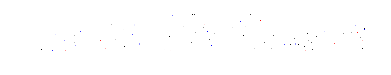

In [199]:
xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

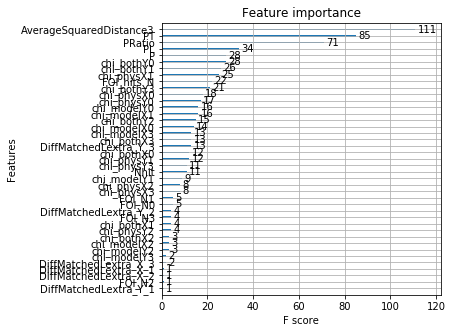

In [262]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [111]:
test.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
id                                                                    
0       55      12      10      15   2.127273   1.166667   1.500000   
1       43      18      12      15   2.697674   1.111111   1.333333   
2       90      34      19      29   1.800000   2.058824   1.210526   
3      141      43      15      16   4.609929   2.744186   1.466667   
4       22      18       8       9   1.636364   2.444444   1.000000   

    avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
id                                                            
0    1.600000     8                   2                   2   
1    1.600000     8                   2                   2   
2    1.344828     8                   2                   2   
3    1.125000     8                   2                   2   
4    1.555556     8                   2                   2   

    MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  \
id                                                                             
0                    2                   2        -22.33000         13.76000   
1                    2                   2      -1070.45500      -1156.07500   
2                    2                   2      -3348.08000      -3614.30000   
3                    1                   2       -213.62167       -238.30833   
4                    1                   1       -446.33835       -496.34167   

    MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  \
id                                                                       
0          60.00000          65.7200      -1849.33730      -1833.79680   
1       -1202.87000       -1286.0700       -222.24156       -240.82657   
2       -3848.97000       -4113.1700      -1628.13240      -1758.31680   
3        -258.33667        -293.3700        483.45386        520.71850   
4        -550.00336        -588.4033        264.65280        284.41754   

    MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  \
id                                                                       
0       -1968.07280      -2102.56400        15396.441        16404.695   
1        -258.19052       -274.01960        15117.299        16321.432   
2       -1887.17990      -2014.60830        15112.236        16315.968   
3         559.30420        663.87054        15119.840        16324.174   
4         305.50333        328.02402        15203.053        16407.324   

    MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  \
id                                                                         
0         17597.812        18806.229         12.750000         13.750000   
1         17514.170        18722.213          6.375000          6.875000   
2         17508.303        18715.945         25.500000         27.500000   
3         17517.113        18926.592          3.208333          3.458333   
4         17600.200        18808.380          3.208333          3.458333   

    MatchedHit_DX[2]  MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  \
id                                                                           
0          59.000000         63.000000         63.078957         68.078926   
1          29.500000         31.500000         31.479162         33.979145   
2         118.000000        126.000000        126.278550        136.278490   
3          14.833333         31.500000         15.679264         16.929256   
4          14.833333         15.833333         15.679264         16.929256   

    MatchedHit_DY[2]  MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
id                                                                           
0          73.078896         78.078860         33.727364         33.745370   
1          36.479130         38.979115         33.613575         33.622578   
2         146.278410        156.278350         33.954950         33.99096

In [15]:
test_selected = test[FEATURE_COLUMNS2]

In [16]:
test_selected.columns = FEATURE_COLUMNS2_NOBRACKET

In [17]:
test_selected.head()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0  region_0  region_1  \
id                                                                        
0         49.569439      691.857817      642.288378         2         2   
1        381.911386     3901.816194     3519.904807         4         4   
2        105.563836     1425.635686     1320.071851         3         3   
3        307.245415     4184.323992     3877.078577         4         4   
4         62.168111     1012.800651      950.632540         2         2   

    region_2  region_3  FOI_hits_N           PT             P  PCat    PRatio  \
id                                                                              
0          2         2           5  2589.074895  50268.359507     7  0.051505   
1          4         4           8  1214.306768   9136.633410     2  0.132905   
2          3         3           5  4021.866299  46241.344045     6  0.086976   
3          4         4           5  2900.460154  14855.922836     3  0.195239   
4          2         3           9  1915.277178  21442.937297     4  0.089320   

    DiffMatchedLextra_X_0  DiffMatchedLextra_X_1  DiffMatchedLextra_X_2  \
id                                                                        
0                -3.34896                6.23768                9.47935   
1               -91.52770             -147.56670             -188.05560   
2                 7.16269               24.01023              -27.86222   
3                16.13240               50.86860               58.05500   
4                24.78090               29.33082               32.45573   

    DiffMatchedLextra_X_3  DiffMatchedLextra_Y_0  DiffMatchedLextra_Y_1  \
id                                                                        
0                20.32600               29.57376               31.34953   
1              -344.27400              -52.20413              -56.88930   
2               -37.75468                5.07490                5.44470   
3                90.81100               82.15770               86.91760   
4                13.02564              -21.61595              -24.29194   

    DiffMatchedLextra_Y_2  DiffMatchedLextra_Y_3   InvASD3  chi_physX0  \
id                                                                       
0                33.09457               34.52456  0.233682    0.275969   
1               -60.45330              259.51910  0.080099   12.883229   
2                 5.78410                5.90810  0.472219    0.315596   
3                92.89850              100.41430  0.291760    0.400237   
4               -25.64684              -25.56690  0.176491   15.110324   

    chi_modelX0  chi_physY0  chi_modelY0  chi_physX1  chi_modelX1  chi_physY1  \
id                                                                              
0      0.575030    0.882606    44.800319    0.823191     0.693670    0.851211   
1     11.718565    0.170903     4.075251   28.794619    10.500708    0.174264   
2      2.148570    0.006473     1.070811    3.049209     8.340052    0.006396   
3      0.944977    0.423289    26.191059    3.421639     3.287134    0.406781   
4      6.393296    0.471522     4.849169   18.201325     3.090295    0.511092   

    chi_modelY1  chi_physX2  chi_modelX2  chi_physY2  chi_modelY2  chi_physX3  \
id                                                                              
0     17.505164    0.103255     0.724522    0.823047     8.822777    0.416373   
1      1.668319    2.539853     7.382547    0.170797     0.815549    7.465645   
2      0.425779    0.223012     5.104138    0.006265     0.218385    0.359137   
3     10.255741    0.242056     1.896806    0.403327     5.190328    0.519441   
4      2.113021    1.210427     1.684133    0.494287     1.048309    0.170992   

    chi_modelX3  chi_physY3  chi_modelY3  FOI_N0  FOI_N1  FOI_N2  FOI_N3  \
id                                                                         
0      1.754722    0.784499     5.057761       2   

In [18]:
n_folds = 2
for i in range(n_folds):
    modelname = "XGB_20190208_9_22_" + str(i)
    modeldir="../models"
    model_read = joblib.load(modeldir + '/' + modelname + ".pkl")
    predictions = model_read.predict_proba(test_selected)[:,1]
    submissionname = "xgb2_private_" + str(i)
    submissiondir = "../submission"
    pd.DataFrame(data={"prediction":predictions}, 
                 index=test_selected.index).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=utils.ID_COLUMN)


In [19]:
!ls -lt ../submission/

total 3632880
-rw-r--r--   1 m_nakao  staff  25549257 Feb 10 15:43 xgb2_private_1.csv
-rw-r--r--   1 m_nakao  staff  25548211 Feb 10 15:43 xgb2_private_0.csv
-rw-r--r--   1 m_nakao  staff  18711952 Feb 10 11:40 average.csv
-rw-r--r--   1 m_nakao  staff  17336018 Feb 10 11:34 stacking_20190209_5_33.csv
-rw-r--r--   1 m_nakao  staff  12526094 Feb 10 10:57 stacking_20190209_5_33_2.csv
-rw-r--r--   1 m_nakao  staff  12517881 Feb 10 10:56 stacking_20190209_5_33_1.csv
-rw-r--r--   1 m_nakao  staff  12478794 Feb 10 10:56 stacking_20190209_5_33_0.csv
-rw-r--r--   1 m_nakao  staff  12394022 Feb  9 21:51 stacking_20190209_5_0_2.csv
-rw-r--r--   1 m_nakao  staff  12563146 Feb  9 21:51 stacking_20190209_5_0_1.csv
-rw-r--r--   1 m_nakao  staff  12519168 Feb  9 21:51 stacking_20190209_5_0_0.csv
-rw-r--r--   1 m_nakao  staff  12499016 Feb  9 21:19 stacking_20190209_4.csv
-rw-r--r--   1 m_nakao  staff  17572858 Feb  9 20:37 stacking_20190209_3_0.csv
-rw-r--r--   1 m_nakao  staff  12499016 Feb  9 20:31

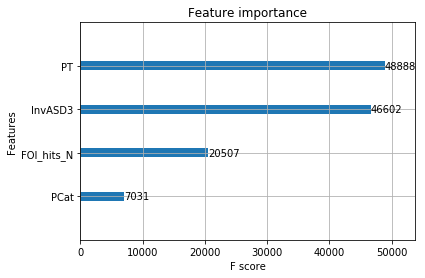

In [56]:
xgb.plot_importance(model_read)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [323]:
!ls -lt ../models/

total 17177808
-rw-r--r--  1 m_nakao  staff    1313234 Feb  6 17:55 XGB_20190206_13_0_1.pkl
-rw-r--r--  1 m_nakao  staff    1296674 Feb  6 17:55 XGB_20190206_13_0_0.pkl
-rw-r--r--  1 m_nakao  staff    1084682 Feb  6 17:54 XGB_20190206_12_0_1.pkl
-rw-r--r--  1 m_nakao  staff    1131050 Feb  6 17:54 XGB_20190206_12_0_0.pkl
-rw-r--r--  1 m_nakao  staff    2116154 Feb  6 17:54 XGB_20190206_11_0_1.pkl
-rw-r--r--  1 m_nakao  staff    2091890 Feb  6 17:54 XGB_20190206_11_0_0.pkl
-rw-r--r--  1 m_nakao  staff     940426 Feb  6 17:53 XGB_20190206_10_0_1.pkl
-rw-r--r--  1 m_nakao  staff     937906 Feb  6 17:53 XGB_20190206_10_0_0.pkl
-rw-r--r--  1 m_nakao  staff    2729346 Feb  6 17:53 XGB_20190206_9_0_1.pkl
-rw-r--r--  1 m_nakao  staff    2735970 Feb  6 17:52 XGB_20190206_9_0_0.pkl
-rw-r--r--  1 m_nakao  staff    1925746 Feb  6 17:50 XGB_20190206_8_0_1.pkl
-rw-r--r--  1 m_nakao  staff    1922146 Feb  6 17:50 XGB_20190206_8_0_0.pkl
-rw-r--r--  1 m_nakao  staff    4147866 Feb  6 17:48 XGB_20190206

In [337]:
tpmask = ((test_selected['PCat'] > 7) & (test_selected['PCat'] < 9))

In [338]:
    modelname = "XGB_20190206_13_0_0"
    modeldir="../models"
    model_read = joblib.load(modeldir + '/' + modelname + ".pkl")
    predictions = model_read.predict_proba(test_selected[tpmask])[:,1]
    submissionname = "XGB_20190206_p_5"
    submissiondir = "../submission"
    pd.DataFrame(data={"prediction":predictions}, 
                 index=test_selected[tpmask].index).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=utils.ID_COLUMN)

In [339]:
!ls -lt ../submission/

total 2318432
-rw-r--r--  1 m_nakao  staff   1505529 Feb  6 18:11 XGB_20190206_p_5.csv
-rw-r--r--  1 m_nakao  staff    566425 Feb  6 18:10 XGB_20190206_p_4.csv
-rw-r--r--  1 m_nakao  staff    856418 Feb  6 18:10 XGB_20190206_p_3.csv
-rw-r--r--  1 m_nakao  staff   1326945 Feb  6 18:10 XGB_20190206_p_2.csv
-rw-r--r--  1 m_nakao  staff   5791814 Feb  6 18:09 XGB_20190206_p_1.csv
-rw-r--r--  1 m_nakao  staff   2504125 Feb  6 18:09 XGB_20190206_p_0.csv
-rw-r--r--  1 m_nakao  staff  17396667 Feb  6 17:27 XGB_20190206_4_0.csv
-rw-r--r--  1 m_nakao  staff  12416671 Feb  6 17:26 XGB_20190206_4_0_2.csv
-rw-r--r--  1 m_nakao  staff  12516566 Feb  6 17:26 XGB_20190206_4_0_1.csv
-rw-r--r--  1 m_nakao  staff  12589454 Feb  6 17:26 XGB_20190206_4_0_0.csv
-rw-r--r--  1 m_nakao  staff  12539656 Feb  6 17:21 XGB_20190206_3_0_2.csv
-rw-r--r--  1 m_nakao  staff  12539574 Feb  6 17:21 XGB_20190206_3_0_1.csv
-rw-r--r--  1 m_nakao  staff  12537797 Feb  6 17:21 XGB_20190206_3_0_0.csv
-rw-r--r--  1 m_nakao  st

### どのモデルを使うかによって下記functionのコメントアウトを変える.

In [116]:
def function(args):
   print(args)
   # clf = RandomForestClassifier(**args, n_jobs = -1)
   # clf = ExtraTreesClassifier(**args, n_jobs = -1)
   clf = GradientBoostingClassifier(**args)
   #clf = XGBClassifier(**args, n_jobs = -1, sample_weight = y_train['weight'])
   clf.fit(X_train, y_train['label'])
   score0 =  accuracy_score(y_test['label'], clf.predict(X_test))
   print('Accuracy(clf): %.5f' % score0)
   predictions_score_predict = clf.predict_proba(X_test)[:,1]
   labels_score_predict = y_test['label'].values
   weights_score_predict = y_test['weight'].values
   score = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
   print('Weighted(clf): %.5f' % score)
   print(clf.feature_importances_)
   return -score

### ハイパーパラメータ探索をする.
- 途中に表示されているのは各特徴量の重要度
- 一番下に出力されるのが探索範囲の中でもっともいいパラメータの組み合わせ.

In [117]:
# best = fmin(function, parameter_space_RF, algo=tpe.suggest, max_evals=100)
best = fmin(function, parameter_space_GB, algo=tpe.suggest, max_evals=6)
#best = fmin(function, parameter_space_X, algo=tpe.suggest, max_evals=5)
print("best parameters:")
print(best)
# clf = RandomForestClassifier(**best)
# clf = ExtraTreesClassifier(**best)
clf = GradientBoostingClassifier(**best)
#clf = XGBClassifier(**best)

{'learning_rate': 0.042301448355816715, 'loss': 'deviance', 'max_depth': 7.0, 'max_features': None, 'subsample': 0.75}
Accuracy(clf): 0.75677
Weighted(clf): 0.76390
[9.98930856e-03 1.85590762e-02 8.89997353e-03 7.33271012e-04
 3.63583883e-02 1.40702165e-02 2.12445953e-02 1.84284678e-02
 1.49697667e-02 1.65375166e-02 1.15425132e-02 1.20538556e-02
 1.31754160e-02 1.72957031e-02 1.44979854e-01 1.98044707e-06
 1.48053719e-01 1.19289392e-02 1.12165887e-02 4.75098977e-03
 7.78588615e-03 8.27443333e-03 7.53218644e-03 6.27306908e-03
 7.54460238e-03 8.74378059e-03 1.21829366e-02 1.08738520e-02
 6.79550746e-03 7.48765911e-03 6.03292209e-03 8.82446096e-03
 1.23859305e-02 6.77317143e-03 5.02352270e-03 7.82458428e-03
 8.81807044e-03 9.37714744e-03 6.26326231e-03 1.02968186e-02
 5.12341861e-03 4.93457826e-03 3.05162588e-03 8.99999696e-03
 1.03678405e-02 8.96896125e-03 7.78813880e-03 6.06914294e-03
 7.54721943e-03 5.18418804e-03 3.28558199e-03 2.60301392e-03
 1.35780785e-03 1.06600946e-02 8.24783824e

In [92]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0, max_delta_step=0,
       max_depth=0, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### 一番よかったものを保存する.

In [118]:
model = GradientBoostingClassifier(n_estimators=100, loss = 'deviance', learning_rate = 0.042301448355816715, max_depth = 7.0, subsample = 0.75, max_features = None)


In [191]:
model = XGBClassifier(n_estimators=150, gamma = 0.8176266873363986, 
                      learning_rate = 0.03995739671028172, max_depth = 6, 
                      reg_lambda = 0.5, subsample = 0.9, n_jobs = -1)



#### 一部のデータで学習

In [192]:
X_train.shape

(13095, 79)

In [193]:
model.fit(X_train, y_train['label'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.8176266873363986,
       learning_rate=0.03995739671028172, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [194]:
predictions_score_predict = model.predict_proba(X_test)[:,1]
labels_score_predict = y_test['label'].values
weights_score_predict = y_test['weight'].values
score = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
print(score)

0.7482551701520574


#### sampleデータで学習

In [136]:
sample.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
1595363      62      49      17      19   3.241935   2.693878   1.882353   
2885605      29      15       6      11   1.931034   4.066667   1.833333   
593788       74       4      19       5   2.837838   1.000000   1.842105   
809946       51      33      13      12   1.470588   2.242424   1.230769   
4504781      52      38      23      12   1.673077   2.368421   1.869565   

         avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
1595363   1.263158     8                   2                   2   
2885605   1.363636     8                   2                   2   
593788    1.000000     8                   2                   2   
809946    1.333333     6                   2                   2   
4504781   1.083333     8                   2                   2   

         MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
1595363                   1                   1        47.258335   
2885605                   2                   2     -1952.130000   
593788                    2                   2       395.300000   
809946                    0                   2     -3740.180000   
4504781                   1                   1       602.725000   

         MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
1595363        237.41833        348.06668        182.98666       -302.36170   
2885605      -2133.45000      -2301.87000      -2584.67000      -1332.33810   
593788         481.26000        532.00000        569.72000       1821.52590   
809946       -4198.80000      -9999.00000      -5121.97000      -3423.12450   
4504781        650.03500        694.56665        711.62000       -111.15913   

         MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
1595363       -360.15760       -423.08414       -373.92650        15319.911   
2885605      -1437.72270      -1541.78600      -1644.31450        15314.303   
593788        1965.07860       2108.60080       2252.80790        15210.559   
809946       -3692.10800      -9999.00000        464.87314        15306.773   
4504781       -120.05536       -128.98225       -138.22424        15119.599   

         MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
1595363        16527.004        17720.377        18929.453          3.208333   
2885605        16518.123        17710.549        18918.280         12.750000   
593788         16418.375        17612.492        18821.912         12.750000   
809946         16510.006        -9999.000        18808.873         25.500000   
4504781        16326.867        17520.434        18729.300          3.208333   

         MatchedHit_DX[1]  MatchedHit_DX[2]  MatchedHit_DX[3]  \
1595363          3.458333         14.833333         15.833333   
2885605         13.750000         59.000000         63.000000   
593788          13.750000         59.000000         63.000000   
809946          27.500000      -9999.000000        126.000000   
4504781          3.458333         14.833333         15.833333   

         MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
1595363         15.679264         16.929256         18.179249   
2885605         63.078957         68.078926         73.078896   
593788          63.078957         68.078926         73.078896   
809946         126.278550        136.278490      -9999.000000   
4504781         15.679264         16.929256         18.179249   

         MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
1595363          19.42924         33.556680          33.56118   
2885605          78.07886         33.727364          33.74537   
593788           78.07886         33.727364          33.74537   
809946          156.27835         33.954950          33.99096   
4504781          19.42924         33.556680          33.56118   

         MatchedHit_DZ[2]  MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  \
1595363         33.565680         33.570183      

In [138]:
X_train2 = sample[FEATURE_COLUMNS2]
y_train2 = sample[ID_COLUMNS2]

In [140]:
X_train2.describe()

FOI_hits_N            PT             P           PCat  \
count  200000.000000  2.000000e+05  2.000000e+05  200000.000000   
mean        7.509620  2.425409e+03  3.153200e+04       4.000985   
std         5.527793  9.309993e+03  5.717506e+04       2.188965   
min         2.000000  8.000008e+02  3.000094e+03       0.000000   
25%         5.000000  1.189283e+03  1.148392e+04       3.000000   
50%         6.000000  1.769479e+03  2.063028e+04       4.000000   
75%         8.000000  2.873027e+03  3.824065e+04       5.000000   
max       151.000000  4.070073e+06  2.040994e+07       8.000000   

              PRatio            PL  DiffMatchedLextra_X[0]  \
count  200000.000000  2.000000e+05           200000.000000   
mean        0.109973  3.139001e+04                0.562896   
std         0.066361  5.643903e+04               75.186817   
min         0.011114  2.790260e+03            -4628.955800   
25%         0.056687  1.135397e+04              -10.965402   
50%         0.095469  2.049671e+04                0.069140   
75%         0.150781  3.809176e+04               11.663414   
max         0.399337  2.000000e+07             3872.456400   

       DiffMatchedLextra_X[1]  DiffMatchedLextra_X[2]  DiffMatchedLextra_X[3]  \
count           200000.000000           200000.000000           200000.000000   
mean                 0.459270             -162.915930             -186.730675   
std                 96.286656             1292.934080             1441.971127   
min              -6680.716000           -15586.478000           -16057.593300   
25%                -15.957425              -33.936485              -42.665868   
50%                  0.096873               -0.542730               -1.154449   
75%                 16.421225               31.736080               37.700373   
max               9619.764000             4373.382650             8124.251000   

       DiffMatchedLextra_Y[0]  DiffMatchedLextra_Y[1]  DiffMatchedLextra_Y[2]  \
count           200000.000000           200000.000000           200000.000000   
mean                 0.601355                0.533789             -161.919052   
std                 90.043866              128.652860             1296.013977   
min              -2105.530624            -3459.462280           -14470.591000   
25%                -25.799845              -30.269810              -37.069325   
50%                 -0.150660               -0.104930               -0.888540   
75%                 26.737925               31.126025               34.842025   
max               2036.682900             3656.054020             5461.211400   

       DiffMatchedLextra_Y[3]  AverageSquaredDistance3           Nhit  \
count           200000.000000            200000.000000  200000.000000   
mean              -183.111075                10.227553       3.965170   
std               1413.304013                61.171139       0.201289   
min             -14855.508300                 0.033464       2.000000   
25%                -44.479757                 1.914076       4.000000   
50%                 -1.010810                 3.730442       4.000000   
75%                 41.517813                 6.971674       4.000000   
max               6458.440200             24608.913457       4.000000   

             InvASD3      sigma_x_0      sigma_x_1      sigma_x_2  \
count  200000.000000  200000.000000  200000.000000  200000.000000   
mean        0.488125      25.388440      20.125302      17.533830   
std         0.808802      88.427531      80.893547      61.138969   
min         0.000041       0.000000       0.000000      -1.000000   
25%         0.143438       0.000000       0.000000       0.000000   
50%         0.268065       0.000000       0.000000       0.000000   
75%         0.522445      14.254933      13.750000       0.000000   
max        29.882662    3082.715000    3890.855000    3896.335000   

           sigma_x_3      sigma_y_0      sigma_y_1      sigma_y_2  \
count  200000.000000  200000.000000  2

In [141]:
y_train2.describe()

particle_type          label         weight
count  200000.000000  200000.000000  200000.000000
mean        0.984175       0.922625       3.432063
std         0.277714       0.267186      32.563697
min         0.000000       0.000000   -2727.377946
25%         1.000000       1.000000       1.441052
50%         1.000000       1.000000       2.187170
75%         1.000000       1.000000       2.857517
max         2.000000       1.000000    1972.694011

In [142]:
model.fit(X_train2, y_train2['label'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.042301448355816715, loss='deviance',
              max_depth=7.0, max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=0.75, verbose=0,
              warm_start=False)

#### フルデータで学習

In [129]:
train.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  avg_cs[3]  \
0      47      31      13      15   2.000000   1.580645   1.153846   1.133333   
1      92      19      11      26   2.750000   2.789474   1.363636   1.230769   
2     100      21      11      12   2.930000   2.428571   1.181818   1.083333   
3      74      27      13      20   3.067568   2.518518   1.923077   1.300000   
4      18      22       8       8   1.833333   1.954546   1.125000   1.750000   

   ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  MatchedHit_TYPE[2]  \
0     8                   2                   2                   2   
1     8                   2                   2                   2   
2     8                   2                   2                   2   
3     8                   2                   2                   2   
4     8                   2                   2                   2   

   MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  MatchedHit_X[2]  \
0                   2       -2685.0800         -2954.30         -3140.97   
1                   1         739.5500           852.51           827.00   
2                   2       -1595.1300         -1748.45         -1933.97   
3                   2       -1708.8291         -1816.95         -1933.97   
4                   2       -1504.6300         -1651.95         -1815.97   

   MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  MatchedHit_Y[2]  \
0         -3609.17       1373.34810       1481.26220       1590.39750   
1           758.72       2387.72220       2575.97460       2764.19650   
2         -2066.67       -318.64474       -344.52970       -221.99326   
3         -2066.67       -191.40443       -207.12927       -221.99326   
4         -1940.67        941.44840       1014.66280       1089.19820   

   MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  MatchedHit_Z[2]  \
0       1701.06760        15123.045        16327.633        17520.826   
1       2952.10330        15212.598        16420.576        17614.854   
2       -235.32233        15317.953        16522.060        17598.300   
3       -235.32233        15201.410        16405.555        17598.300   
4       1165.16860        15205.489        16409.953        17603.021   

   MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  MatchedHit_DX[2]  \
0        18729.324         25.500000             27.50             118.0   
1        18824.430         25.500000             27.50             118.0   
2        18806.352         12.750000             13.75              59.0   
3        18806.352         12.948485             13.75              59.0   
4        18811.395         12.750000             13.75              59.0   

   MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
0             126.0        126.278550        136.278490        146.278410   
1             756.0        126.278550        136.278490        146.278410   
2              63.0         63.078957         68.078926         73.078896   
3              63.0         63.038590         68.078926         73.078896   
4              63.0         63.078957         68.078926         73.078896   

   MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  MatchedHit_DZ[2]  \
0         156.27835         33.954950          33.99096         34.026966   
1         156.27835         33.954950          33.99096         34.026966   
2          78.07886         33.727364          33.74537         33.763374   
3          78.07886         33.727220          33.74537         33.763374   
4          78.07886         33.727364          33.74537         33.763374   

   MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  MatchedHit_T[2]  \
0         34.062977                3                2                7   
1         34.062977                9               10                8   
2         33.781380               10                3                3   
3         33.781380                6                4                8   
4

In [144]:
train = (cv.MeasCalculator()).calc_all(train)

In [145]:
train_full = train[FEATURE_COLUMNS2]

In [146]:
train_full.columns = FEATURE_COLUMNS2_NOBRACKET

In [147]:
y_train_full = train[ID_COLUMNS]

In [148]:
train_full.tail()

PT             P  PCat    PRatio        PL  \
5445700  4587.294517  36460.924020     5  0.125814  36171.20   
5445701  1475.369428   9361.638135     2  0.157597   9244.65   
5445702   892.313223  34413.250496     5  0.025929  34401.68   
5445703  3840.569638  79618.333210     8  0.048237  79525.65   
5445704  1400.590265   8175.248637     2  0.171321   8054.38   

         DiffMatchedLextra_X_0  DiffMatchedLextra_X_1  DiffMatchedLextra_X_2  \
5445700             -13.316400             -26.321600              -86.74680   
5445701              -9.581300             -52.593700              -19.47630   
5445702              -9.816900             -16.977250              -36.21254   
5445703               3.028625              -3.309534               13.50730   
5445704             -56.048500             -97.437000             -136.19570   

         DiffMatchedLextra_X_3  DiffMatchedLextra_Y_0  DiffMatchedLextra_Y_1  \
5445700              -77.49200               21.56525               22.57350   
5445701              -68.12860              -82.41130              -83.10060   
5445702              -26.25290               -5.75848               -6.99573   
5445703               10.52915                6.62946                6.56250   
5445704             -201.62430               92.55520             -154.55250   

         DiffMatchedLextra_Y_2  DiffMatchedLextra_Y_3  \
5445700               23.55100               24.21350   
5445701              -89.82310              -96.86070   
5445702               -7.11191               -5.59321   
5445703                6.46494                6.05233   
5445704             -168.09350             -182.04980   

         AverageSquaredDistance3   InvASD3  
5445700                 5.626832  0.177720  
5445701                 1.866045  0.535893  
5445702                 4.980925  0.200766  
5445703                 0.776929  1.287119  
5445704                 6.481625  0.154282

In [149]:
y_train_full.tail()

particle_type
5445700              1
5445701              1
5445702              1
5445703              1
5445704              1

In [124]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.8, learning_rate=0.10664128692740758,
       max_delta_step=0, max_depth=55, min_child_weight=2.0, missing=None,
       n_estimators=100, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)

In [150]:
model.fit(train_full, train['particle_type'], sample_weight=train['weight'])

[10:04:01] Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.5, learning_rate=0.05532302579765159,
       max_delta_step=0, max_depth=21, min_child_weight=1.0, missing=None,
       n_estimators=150, n_jobs=-1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=0.75, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

### 保存

In [195]:
modelname = "XGB_20190203_2"
modeldir="../models"

In [196]:
joblib.dump(model, modeldir + '/' + modelname + ".pkl")

['../models/XGB_20190203_2.pkl']

In [197]:
test.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
id                                                                    
0       55      12      10      15   2.127273   1.166667   1.500000   
1       43      18      12      15   2.697674   1.111111   1.333333   
2       90      34      19      29   1.800000   2.058824   1.210526   
3      141      43      15      16   4.609929   2.744186   1.466667   
4       22      18       8       9   1.636364   2.444444   1.000000   

    avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
id                                                            
0    1.600000     8                   2                   2   
1    1.600000     8                   2                   2   
2    1.344828     8                   2                   2   
3    1.125000     8                   2                   2   
4    1.555556     8                   2                   2   

    MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  \
id                                                                             
0                    2                   2        -22.33000         13.76000   
1                    2                   2      -1070.45500      -1156.07500   
2                    2                   2      -3348.08000      -3614.30000   
3                    1                   2       -213.62167       -238.30833   
4                    1                   1       -446.33835       -496.34167   

    MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  \
id                                                                       
0          60.00000          65.7200      -1849.33730      -1833.79680   
1       -1202.87000       -1286.0700       -222.24156       -240.82657   
2       -3848.97000       -4113.1700      -1628.13240      -1758.31680   
3        -258.33667        -293.3700        483.45386        520.71850   
4        -550.00336        -588.4033        264.65280        284.41754   

    MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  \
id                                                                       
0       -1968.07280      -2102.56400        15396.441        16404.695   
1        -258.19052       -274.01960        15117.299        16321.432   
2       -1887.17990      -2014.60830        15112.236        16315.968   
3         559.30420        663.87054        15119.840        16324.174   
4         305.50333        328.02402        15203.053        16407.324   

    MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  \
id                                                                         
0         17597.812        18806.229         12.750000         13.750000   
1         17514.170        18722.213          6.375000          6.875000   
2         17508.303        18715.945         25.500000         27.500000   
3         17517.113        18926.592          3.208333          3.458333   
4         17600.200        18808.380          3.208333          3.458333   

    MatchedHit_DX[2]  MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  \
id                                                                           
0          59.000000         63.000000         63.078957         68.078926   
1          29.500000         31.500000         31.479162         33.979145   
2         118.000000        126.000000        126.278550        136.278490   
3          14.833333         31.500000         15.679264         16.929256   
4          14.833333         15.833333         15.679264         16.929256   

    MatchedHit_DY[2]  MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
id                                                                           
0          73.078896         78.078860         33.727364         33.745370   
1          36.479130         38.979115         33.613575         33.622578   
2         146.278410        156.278350         33.954950         33.99096

In [133]:
test.describe()

ncl[0]         ncl[1]         ncl[2]         ncl[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean       62.811942      19.554897      12.448600      13.012038   
std        32.264048      12.681014       7.451726       6.375977   
min         2.000000       0.000000       0.000000       0.000000   
25%        39.000000      10.000000       7.000000       8.000000   
50%        58.000000      17.000000      11.000000      12.000000   
75%        82.000000      26.000000      16.000000      16.000000   
max       285.000000     196.000000      84.000000      81.000000   

           avg_cs[0]      avg_cs[1]      avg_cs[2]      avg_cs[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean        2.466626       2.118251       1.447288       1.359854   
std         0.657863       0.778726       0.368397       0.430181   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.012987       1.571428       1.185185       1.125000   
50%         2.386792       2.000000       1.388889       1.285714   
75%         2.822581       2.500000       1.636364       1.500000   
max        10.904762      25.666666       9.571428      16.500000   

                ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
count  726095.000000       726095.000000       726095.000000   
mean        7.931243            1.962469            1.964324   
std         0.400455            0.190059            0.185481   
min         4.000000            1.000000            1.000000   
25%         8.000000            2.000000            2.000000   
50%         8.000000            2.000000            2.000000   
75%         8.000000            2.000000            2.000000   
max         8.000000            2.000000            2.000000   

       MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
count       726095.000000       726095.000000    726095.000000   
mean             1.800077            1.788570        -0.265976   
std              0.439050            0.450192      1547.473481   
min              0.000000            0.000000     -4862.180000   
25%              2.000000            2.000000      -815.455000   
50%              2.000000            2.000000         7.558333   
75%              2.000000            2.000000       813.075000   
max              2.000000            2.000000      4832.950000   

       MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -0.494001      -164.333201      -183.128382        -4.334283   
std        1690.196022      2218.311490      2344.461028      1346.489794   
min       -5243.800000     -9999.000000     -9999.000000     -3951.223600   
25%        -884.325000     -1042.870000     -1114.070000      -793.841700   
50%           8.068334       -37.870000       -41.370000       -32.562122   
75%         883.185000       918.600000       982.220000       783.449400   
max        5209.310000      5557.000000      5933.120000      3898.132300   

       MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -5.034248      -168.809096      -183.127655     15261.422972   
std        1450.342314      1990.991526      2090.162551       108.476325   
min       -4259.906700     -9999.000000     -9999.000000     15105.030000   
25%        -857.026370      -958.983150     -1023.974800     15190.861000   
50%         -35.208393       -74.082610       -78.923350     15257.947000   
75%         844.163940       902.111100       932.315700     15332.404000   
max        4205.364300      4512.695300      4820.811000     15418.309000   

       MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
count    726095.000000    726095.000000    726095.000000     726095.000000   
mean      16467.135053     17206.558442     18349.6402

In [198]:
test.dtypes

ncl[0]                       int64
ncl[1]                       int64
ncl[2]                       int64
ncl[3]                       int64
avg_cs[0]                  float64
avg_cs[1]                  float64
avg_cs[2]                  float64
avg_cs[3]                  float64
ndof                         int64
MatchedHit_TYPE[0]           int64
MatchedHit_TYPE[1]           int64
MatchedHit_TYPE[2]           int64
MatchedHit_TYPE[3]           int64
MatchedHit_X[0]            float64
MatchedHit_X[1]            float64
MatchedHit_X[2]            float64
MatchedHit_X[3]            float64
MatchedHit_Y[0]            float64
MatchedHit_Y[1]            float64
MatchedHit_Y[2]            float64
MatchedHit_Y[3]            float64
MatchedHit_Z[0]            float64
MatchedHit_Z[1]            float64
MatchedHit_Z[2]            float64
MatchedHit_Z[3]            float64
MatchedHit_DX[0]           float64
MatchedHit_DX[1]           float64
MatchedHit_DX[2]           float64
MatchedHit_DX[3]    

In [199]:
test.describe()

ncl[0]         ncl[1]         ncl[2]         ncl[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean       62.811942      19.554897      12.448600      13.012038   
std        32.264048      12.681014       7.451726       6.375977   
min         2.000000       0.000000       0.000000       0.000000   
25%        39.000000      10.000000       7.000000       8.000000   
50%        58.000000      17.000000      11.000000      12.000000   
75%        82.000000      26.000000      16.000000      16.000000   
max       285.000000     196.000000      84.000000      81.000000   

           avg_cs[0]      avg_cs[1]      avg_cs[2]      avg_cs[3]  \
count  726095.000000  726095.000000  726095.000000  726095.000000   
mean        2.466626       2.118251       1.447288       1.359854   
std         0.657863       0.778726       0.368397       0.430181   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.012987       1.571428       1.185185       1.125000   
50%         2.386792       2.000000       1.388889       1.285714   
75%         2.822581       2.500000       1.636364       1.500000   
max        10.904762      25.666666       9.571428      16.500000   

                ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
count  726095.000000       726095.000000       726095.000000   
mean        7.931243            1.962469            1.964324   
std         0.400455            0.190059            0.185481   
min         4.000000            1.000000            1.000000   
25%         8.000000            2.000000            2.000000   
50%         8.000000            2.000000            2.000000   
75%         8.000000            2.000000            2.000000   
max         8.000000            2.000000            2.000000   

       MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  \
count       726095.000000       726095.000000    726095.000000   
mean             1.800077            1.788570        -0.265976   
std              0.439050            0.450192      1547.473481   
min              0.000000            0.000000     -4862.180000   
25%              2.000000            2.000000      -815.455000   
50%              2.000000            2.000000         7.558333   
75%              2.000000            2.000000       813.075000   
max              2.000000            2.000000      4832.950000   

       MatchedHit_X[1]  MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -0.494001      -164.333201      -183.128382        -4.334283   
std        1690.196022      2218.311490      2344.461028      1346.489794   
min       -5243.800000     -9999.000000     -9999.000000     -3951.223600   
25%        -884.325000     -1042.870000     -1114.070000      -793.841700   
50%           8.068334       -37.870000       -41.370000       -32.562122   
75%         883.185000       918.600000       982.220000       783.449400   
max        5209.310000      5557.000000      5933.120000      3898.132300   

       MatchedHit_Y[1]  MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  \
count    726095.000000    726095.000000    726095.000000    726095.000000   
mean         -5.034248      -168.809096      -183.127655     15261.422972   
std        1450.342314      1990.991526      2090.162551       108.476325   
min       -4259.906700     -9999.000000     -9999.000000     15105.030000   
25%        -857.026370      -958.983150     -1023.974800     15190.861000   
50%         -35.208393       -74.082610       -78.923350     15257.947000   
75%         844.163940       902.111100       932.315700     15332.404000   
max        4205.364300      4512.695300      4820.811000     15418.309000   

       MatchedHit_Z[1]  MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  \
count    726095.000000    726095.000000    726095.000000     726095.000000   
mean      16467.135053     17206.558442     18349.6402

In [200]:
test_selected = test[FEATURE_COLUMNS2]

In [201]:
test_selected.head()

FOI_hits_N           PT             P  PCat    PRatio        PL  \
id                                                                    
0            6  1174.484530   6884.502272     1  0.170598   6783.58   
1            7  4344.639775  48769.526891     6  0.089085  48575.62   
2            4  4109.805750  20296.048412     4  0.202493  19875.59   
3            9   940.242439  26062.046122     4  0.036077  26045.08   
4            8  1386.377851  59872.343332     7  0.023156  59856.29   

    DiffMatchedLextra_X[0]  DiffMatchedLextra_X[1]  DiffMatchedLextra_X[2]  \
id                                                                           
0                -2.290999              -41.915945               -71.39090   
1                 7.529900               -3.351200                24.59260   
2                38.099400               64.605300               122.66130   
3                12.293410               25.395950                43.15683   
4                -1.777010               -8.109370               -18.10010   

    DiffMatchedLextra_X[3]  DiffMatchedLextra_Y[0]  DiffMatchedLextra_Y[1]  \
id                                                                           
0               -141.38583               -52.02300               102.23580   
1                 16.13150                34.86269                36.60583   
2                151.18740                -0.80790                -3.37530   
3                 45.91270               -13.17938               -14.89780   
4                -12.82900                 3.66174                 2.82132   

    DiffMatchedLextra_Y[2]  DiffMatchedLextra_Y[3]  AverageSquaredDistance3  \
id                                                                            
0                106.67820               110.90520                 3.179820   
1                 39.57004                44.06910                 6.049038   
2                 -4.62130                -4.43260                 5.244695   
3                -15.29510                50.28820                 7.825575   
4                  3.30193                 5.21747                 1.746150   

    Nhit   InvASD3  sigma_x_0   sigma_x_1  sigma_x_2  sigma_x_3  sigma_y_0  \
id                                                                           
0      4  0.314483   0.000000   14.019503   0.000000    0.00000   0.000000   
1      4  0.165316   8.500000   44.687500  29.500000    0.00000  80.652620   
2      4  0.190669   0.000000    0.000000   0.000000    0.00000   0.000000   
3      4  0.127786  15.030523    0.000000  32.106596    0.00000  59.803728   
4      4  0.572688   0.000000  202.679165   0.000000   21.22369   0.000000   

    sigma_y_1  sigma_y_2  sigma_y_3  chi_physX0  chi_modelX0  chi_bothX0  \
id                                                                         
0   72.016832   0.000000    0.00000    0.032287     0.004374    0.003852   
1    0.000000   0.000000    0.00000    1.395141     2.570106    0.904271   
2    0.000000   0.000000    0.00000    2.232317    10.386821    1.837422   
3    0.000000  28.706532    0.00000   14.682019     2.070748    1.814791   
4   41.425980   0.000000   17.95055    0.306776     0.229778    0.131376   

    chi_physY0  chi_modelY0  chi_bothY0  chi_physX1  chi_modelX1  chi_bothX1  \
id                                                                             
0     0.680177     2.235290    0.521492    9.292940     0.512037    0.485297   
1     1.226522    55.287497    1.199903    0.237605     0.176091    0.101137   
2     0.000041     0.004894    0.000041    5.519134    10.388201    3.604241   
3     0.706543     2.379956    0.544805   53.925631     3.047911    2.884857   
4     0.054541     0.976703    0.051656    5.498453     1.683626    1.288950   

    chi_physY1  chi_modelY1  chi_bothY1  chi_physX2  chi_modelX2  chi_bothX2  \
id                                                                             
0     2.255177     3.019034    1.290896    1.464137     0

In [202]:
test_selected.columns = FEATURE_COLUMNS2_NOBRACKET

In [203]:
predictions = model.predict_proba(test_selected)[:,1]

In [204]:
predictions

array([0.72227114, 0.60398227, 0.5110647 , ..., 0.61593264, 0.532631  ,
       0.49568582], dtype=float32)

In [205]:
submissionname = "XGB_20190203_2"
submissiondir = "../submission"

In [206]:
pd.DataFrame(data={"prediction":predictions}, index=test_selected.index).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=utils.ID_COLUMN)




In [333]:
mask =  (sample['LogInvASD3'] > -2.5)

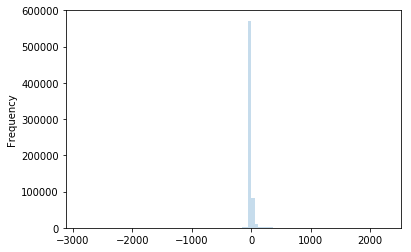

In [180]:
sample[mask].weight.plot.hist(bins=100, alpha=0.25)

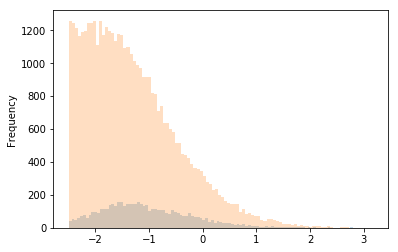

In [457]:
X_train[y_train['label'] == 1].LogInvASD3.plot.hist(bins = 100, alpha = 0.25)
X_train[y_train['label'] == 0].LogInvASD3.plot.hist(bins = 100, alpha = 0.25)

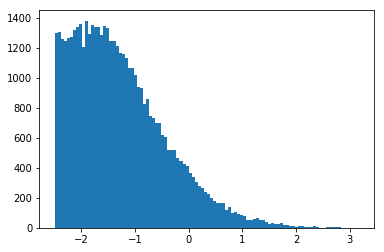

In [459]:
train_LIASD = plt.hist(X_train['LogInvASD3'], bins=100)

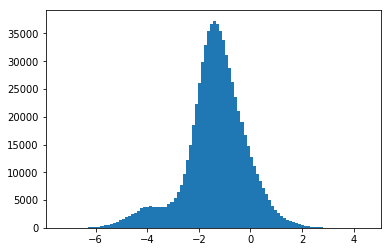

In [460]:
test_LIASD = plt.hist(test_selected['LogInvASD3'], bins=100)

In [223]:
np.delete(train_LIASD[1], 100).shape

(100,)

In [201]:
from sklearn import mixture
import matplotlib.pyplot
import matplotlib.mlab
import numpy as np
from pylab import *
from scipy.optimize import leastsq

[ 2.5e+04 -4.0e+00  1.0e+00  1.0e+01 -1.5e+00  1.0e+00]
[ 2.5e+04 -4.0e+00  1.0e+00  1.0e+01 -1.5e+00  1.0e+00]
[ 2.5e+04 -4.0e+00  1.0e+00  1.0e+01 -1.5e+00  1.0e+00]
[ 2.50000004e+04 -4.00000000e+00  1.00000000e+00  1.00000000e+01
 -1.50000000e+00  1.00000000e+00]
[ 2.50000000e+04 -3.99999994e+00  1.00000000e+00  1.00000000e+01
 -1.50000000e+00  1.00000000e+00]
[ 2.50000000e+04 -4.00000000e+00  1.00000001e+00  1.00000000e+01
 -1.50000000e+00  1.00000000e+00]
[ 2.50000000e+04 -4.00000000e+00  1.00000000e+00  1.00000001e+01
 -1.50000000e+00  1.00000000e+00]
[ 2.50000000e+04 -4.00000000e+00  1.00000000e+00  1.00000000e+01
 -1.49999998e+00  1.00000000e+00]
[ 2.50000000e+04 -4.00000000e+00  1.00000000e+00  1.00000000e+01
 -1.50000000e+00  1.00000001e+00]
[ 1.35509917e+04 -4.84835877e+00  2.44159994e-01  1.14280010e+01
 -1.44385423e+00  9.58775609e-01]
[ 1.35509919e+04 -4.84835877e+00  2.44159994e-01  1.14280010e+01
 -1.44385423e+00  9.58775609e-01]
[ 1.35509917e+04 -4.84835869e+00  2.4415

 -1.34406817e+00  8.74973647e-01]
[ 1.53360031e+04 -4.26860829e+00  5.51733848e-01  1.08750857e+01
 -1.34406817e+00  8.74973647e-01]
[ 1.53360031e+04 -4.26860835e+00  5.51733856e-01  1.08750857e+01
 -1.34406817e+00  8.74973647e-01]
[ 1.53360031e+04 -4.26860835e+00  5.51733848e-01  1.08750859e+01
 -1.34406817e+00  8.74973647e-01]
[ 1.53360031e+04 -4.26860835e+00  5.51733848e-01  1.08750857e+01
 -1.34406815e+00  8.74973647e-01]
[ 1.53360031e+04 -4.26860835e+00  5.51733848e-01  1.08750857e+01
 -1.34406817e+00  8.74973660e-01]
[ 1.58327921e+04 -4.19605243e+00  6.22868013e-01  1.05757598e+01
 -1.34048678e+00  8.70135735e-01]
[ 1.58327923e+04 -4.19605243e+00  6.22868013e-01  1.05757598e+01
 -1.34048678e+00  8.70135735e-01]
[ 1.58327921e+04 -4.19605237e+00  6.22868013e-01  1.05757598e+01
 -1.34048678e+00  8.70135735e-01]
[ 1.58327921e+04 -4.19605243e+00  6.22868022e-01  1.05757598e+01
 -1.34048678e+00  8.70135735e-01]
[ 1.58327921e+04 -4.19605243e+00  6.22868013e-01  1.05757599e+01
 -1.340486

 -1.34175212e+00  8.71590871e-01]
[ 1.65935456e+04 -4.21347458e+00  5.73595520e-01  1.00922335e+01
 -1.34175214e+00  8.71590884e-01]
[ 1.69704681e+04 -4.21387703e+00  5.63165860e-01  9.86377071e+00
 -1.34192921e+00  8.71797396e-01]
[ 1.69704684e+04 -4.21387703e+00  5.63165860e-01  9.86377071e+00
 -1.34192921e+00  8.71797396e-01]
[ 1.69704681e+04 -4.21387697e+00  5.63165860e-01  9.86377071e+00
 -1.34192921e+00  8.71797396e-01]
[ 1.69704681e+04 -4.21387703e+00  5.63165868e-01  9.86377071e+00
 -1.34192921e+00  8.71797396e-01]
[ 1.69704681e+04 -4.21387703e+00  5.63165860e-01  9.86377086e+00
 -1.34192921e+00  8.71797396e-01]
[ 1.69704681e+04 -4.21387703e+00  5.63165860e-01  9.86377071e+00
 -1.34192919e+00  8.71797396e-01]
[ 1.69704681e+04 -4.21387703e+00  5.63165860e-01  9.86377071e+00
 -1.34192921e+00  8.71797409e-01]
[ 1.68855109e+04 -4.20799396e+00  5.70093149e-01  9.91986725e+00
 -1.34164870e+00  8.71368188e-01]
[ 1.68855111e+04 -4.20799396e+00  5.70093149e-01  9.91986725e+00
 -1.341648

 -1.34178516e+00  8.71542596e-01]
[ 1.69317686e+04 -4.20972702e+00  5.66509380e-01  9.89240657e+00
 -1.34178514e+00  8.71542596e-01]
[ 1.69317686e+04 -4.20972702e+00  5.66509380e-01  9.89240657e+00
 -1.34178516e+00  8.71542609e-01]
[ 1.69345217e+04 -4.21003545e+00  5.66050000e-01  9.89070146e+00
 -1.34180658e+00  8.71570159e-01]
[ 1.69345219e+04 -4.21003545e+00  5.66050000e-01  9.89070146e+00
 -1.34180658e+00  8.71570159e-01]
[ 1.69345217e+04 -4.21003538e+00  5.66050000e-01  9.89070146e+00
 -1.34180658e+00  8.71570159e-01]
[ 1.69345217e+04 -4.21003545e+00  5.66050009e-01  9.89070146e+00
 -1.34180658e+00  8.71570159e-01]
[ 1.69345217e+04 -4.21003545e+00  5.66050000e-01  9.89070161e+00
 -1.34180658e+00  8.71570159e-01]
[ 1.69345217e+04 -4.21003545e+00  5.66050000e-01  9.89070146e+00
 -1.34180656e+00  8.71570159e-01]
[ 1.69345217e+04 -4.21003545e+00  5.66050000e-01  9.89070146e+00
 -1.34180658e+00  8.71570172e-01]
[ 1.69367922e+04 -4.20976758e+00  5.66307416e-01  9.88944502e+00
 -1.341790

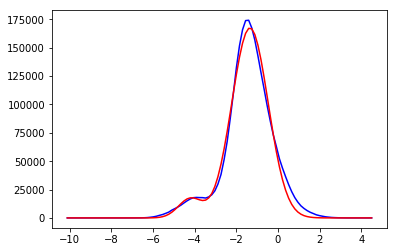

In [289]:
x = np.delete(train_LIASD[1], 100)
y = train_LIASD[0]

def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * (np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))
    print(params)
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y_proc)

# Remove background.
y_proc = np.copy(y)
#y_proc[y_proc < 5] = 0.0

# Least squares fit. Starting values found by inspection.
fit = leastsq( double_gaussian_fit, [25000,-4.0,1.0,10,-1.5,1.0] )
plot( x, y, c='b' )
plot( x, double_gaussian( x, fit[0] ), c='r' )


[ 5.0e+03 -4.5e+00  1.0e+00  1.0e+01 -1.5e+00  5.0e-01]
[ 5.0e+03 -4.5e+00  1.0e+00  1.0e+01 -1.5e+00  5.0e-01]
[ 5.0e+03 -4.5e+00  1.0e+00  1.0e+01 -1.5e+00  5.0e-01]
[ 5.00000007e+03 -4.50000000e+00  1.00000000e+00  1.00000000e+01
 -1.50000000e+00  5.00000000e-01]
[ 5.00000000e+03 -4.49999993e+00  1.00000000e+00  1.00000000e+01
 -1.50000000e+00  5.00000000e-01]
[ 5.00000000e+03 -4.50000000e+00  1.00000001e+00  1.00000000e+01
 -1.50000000e+00  5.00000000e-01]
[ 5.00000000e+03 -4.50000000e+00  1.00000000e+00  1.00000001e+01
 -1.50000000e+00  5.00000000e-01]
[ 5.00000000e+03 -4.50000000e+00  1.00000000e+00  1.00000000e+01
 -1.49999998e+00  5.00000000e-01]
[ 5.00000000e+03 -4.50000000e+00  1.00000000e+00  1.00000000e+01
 -1.50000000e+00  5.00000007e-01]
[ 3.01163236e+03 -4.02237050e+00  1.07084843e+00  1.08762319e+01
 -1.43264967e+00  6.79733851e-01]
[ 3.01163240e+03 -4.02237050e+00  1.07084843e+00  1.08762319e+01
 -1.43264967e+00  6.79733851e-01]
[ 3.01163236e+03 -4.02237044e+00  1.0708

 -1.32336893e+00  8.70474530e-01]
[ 3.16598722e+03 -4.21427175e+00  6.20792363e-01  1.12685106e+01
 -1.32300772e+00  8.70083154e-01]
[ 3.16598727e+03 -4.21427175e+00  6.20792363e-01  1.12685106e+01
 -1.32300772e+00  8.70083154e-01]
[ 3.16598722e+03 -4.21427168e+00  6.20792363e-01  1.12685106e+01
 -1.32300772e+00  8.70083154e-01]
[ 3.16598722e+03 -4.21427175e+00  6.20792372e-01  1.12685106e+01
 -1.32300772e+00  8.70083154e-01]
[ 3.16598722e+03 -4.21427175e+00  6.20792363e-01  1.12685108e+01
 -1.32300772e+00  8.70083154e-01]
[ 3.16598722e+03 -4.21427175e+00  6.20792363e-01  1.12685106e+01
 -1.32300771e+00  8.70083154e-01]
[ 3.16598722e+03 -4.21427175e+00  6.20792363e-01  1.12685106e+01
 -1.32300772e+00  8.70083167e-01]
[ 3.41417720e+03 -4.21719788e+00  5.77381178e-01  1.03984457e+01
 -1.32379244e+00  8.70944848e-01]
[ 3.41417725e+03 -4.21719788e+00  5.77381178e-01  1.03984457e+01
 -1.32379244e+00  8.70944848e-01]
[ 3.41417720e+03 -4.21719781e+00  5.77381178e-01  1.03984457e+01
 -1.323792

 -1.32329672e+00  8.69896258e-01]
[ 3.63297765e+03 -4.19119290e+00  5.67833446e-01  9.83476681e+00
 -1.32329674e+00  8.69896271e-01]
[ 3.63110299e+03 -4.19040058e+00  5.68937150e-01  9.84008840e+00
 -1.32324458e+00  8.69829087e-01]
[ 3.63110304e+03 -4.19040058e+00  5.68937150e-01  9.84008840e+00
 -1.32324458e+00  8.69829087e-01]
[ 3.63110299e+03 -4.19040052e+00  5.68937150e-01  9.84008840e+00
 -1.32324458e+00  8.69829087e-01]
[ 3.63110299e+03 -4.19040058e+00  5.68937158e-01  9.84008840e+00
 -1.32324458e+00  8.69829087e-01]
[ 3.63110299e+03 -4.19040058e+00  5.68937150e-01  9.84008855e+00
 -1.32324458e+00  8.69829087e-01]
[ 3.63110299e+03 -4.19040058e+00  5.68937150e-01  9.84008840e+00
 -1.32324456e+00  8.69829087e-01]
[ 3.63110299e+03 -4.19040058e+00  5.68937150e-01  9.84008840e+00
 -1.32324458e+00  8.69829100e-01]
[ 3.63189098e+03 -4.19098872e+00  5.68224651e-01  9.83778623e+00
 -1.32328090e+00  8.69875899e-01]
[ 3.63189104e+03 -4.19098872e+00  5.68224651e-01  9.83778623e+00
 -1.323280

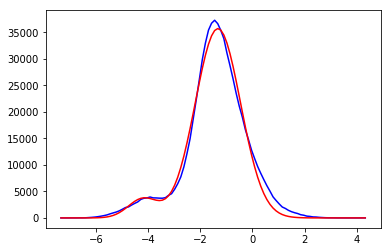

In [258]:
x = np.delete(test_LIASD[1], 100)
y = test_LIASD[0]

def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * (np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) ))
    print(params)
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y_proc)

# Remove background.
y_proc = np.copy(y)
#y_proc[y_proc < 5] = 0.0

# Least squares fit. Starting values found by inspection.
fit = leastsq( double_gaussian_fit, [5000,-4.5,1.0,10,-1.5,0.5],  )
plot( x, y, c='b' )
plot( x, double_gaussian( x, fit[0] ), c='r' )

In [410]:
X_valid[X_valid['LogInvASD3'] > - 2.5].head()

MatchedHit_R_01  MatchedHit_R_1  MatchedHit_R_0     sq_PT  region_0  \
0       288.934501     3304.848891     3015.914390  1.553163         4   
1       213.747407     2713.377681     2499.630274  3.046014         4   
2       155.426228     1782.071300     1626.645071  0.810170         3   
3       109.202878     1828.718086     1719.515208  3.236926         3   
4       163.789241     1938.679809     1774.890568  1.170155         3   

   region_1  region_2  region_3  MatchedHit_DT_0  MatchedHit_DT_1  \
0         4         4         4                0                0   
1         4         4         4                1               -1   
2         3         3         3                0                0   
3         3         3         3                1                0   
4         3         3         3               -2                0   

   MatchedHit_DT_2  MatchedHit_DT_3  FOI_hits_N  NShared  LogInvASD3  \
0                0                0           6        0   -0.580216   
1                0                4           4        1   -1.151731   
2                0                0           9        0   -1.112278   
3                0                0           5        0   -0.077528   
4                0                0           6        0   -0.868289   

   MatchedHit_TYPE_0  MatchedHit_TYPE_1  MatchedHit_TYPE_2  MatchedHit_TYPE_3  \
0                  2                  2                  2                  2   
1                  2                  2                  2                  1   
2                  2                  2                  2                  2   
3                  2                  2                  2                  2   
4                  2                  2                  2                  2   

     PRatio  
0  0.139555  
1  0.157977  
2  0.060746  
3  0.134194  
4  0.080755

In [447]:
parameter_space_RF = {
      'criterion': hp.choice('criterion', ['entropy', 'gini']),
      'max_depth': hp.quniform('max_depth', 3, 50, 1),
      'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
      'bootstrap': hp.choice('bootstrap', [True, False])
}

In [448]:
parameter_space_GB = {
      'loss': hp.choice('loss', ['deviance']),
      'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
      'max_depth': hp.quniform('max_depth', 3, 20, 1),
      'subsample': hp.choice('subsample', [0.5, 0.75, 1, 1, 1, 1]),
      'max_features': hp.choice('max_features', ['sqrt', 'log2', None])
}

In [449]:
 parameter_space_X = {
     'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
     'max_depth':  hp.choice('max_depth', np.arange(3, 20, dtype=int)),
     'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
      'reg_lambda': hp.choice('reg_lambda', [0.5, 0.75, 1]),
     'subsample': hp.choice('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1]),
     'eval_metric': 'auc'
 }